# Tutorial on IBM Molecule Generation Experience (MolGX)　　
<br>
<font color="dimgray">
Package for IBM Molecule Generation Experience (Community Version)

MIT License

Copyright (c) 2022 International Business Machines Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


**MolGX** is a toolkit family to perform molecular generation with a flexible control. MolGX has been developed by IBM Research - Tokyo and has been offered as the **Community Version** as a part of GT4SD. The Community Version provides essential functions selected from the **Enterprise Version**. The purpose of distributing the Community Version is to share such essential technologies with a wide range of communities as well as to furhther improve them through a collaborative, open software development. 

You can also try the <a href="https://molgx.draco.res.ibm.com/ ">**Webapp Vesion**</a> which has access to a minimum set of functions through graphical user interface. 

MolGX supports material discovery processes with user interactions. Its high-level interface is assessible through the <font color="Coral">MolData</font> object and facilitates the complex steps in material discovery. All the intermediate results are stored in the <font color="Coral">MolData</font>  object and can be retrieved whennever they are necessary. You can, therefore, try various feature vectors and regression models in a back-and-forth manner until you can generate final candidate molecules of interest.

MolGX consists of five representative modules: <font color="Coral">DataBox</font>, <font color="Coral">FeatureExtaction</font>,  <font color="Coral">Prediction</font>, <font color="Coral">FeatureEstimation</font>, and <font color="Coral">Generation</font>, which correspond to the following steps.
- Data prepartion
    1. Obtain molecule data and their properties
- Forward problem
    2. Extract features from molecular structures
    3. Perdict target properties by regression models
- Inverse problem
    4. Estimate features  for target property values
    5. Generate molecular structures

This notebook provides an example of performing these steps by only using the high-level interfaces  in the <font color="Coral">DataBox.DataModel</font> python object. 

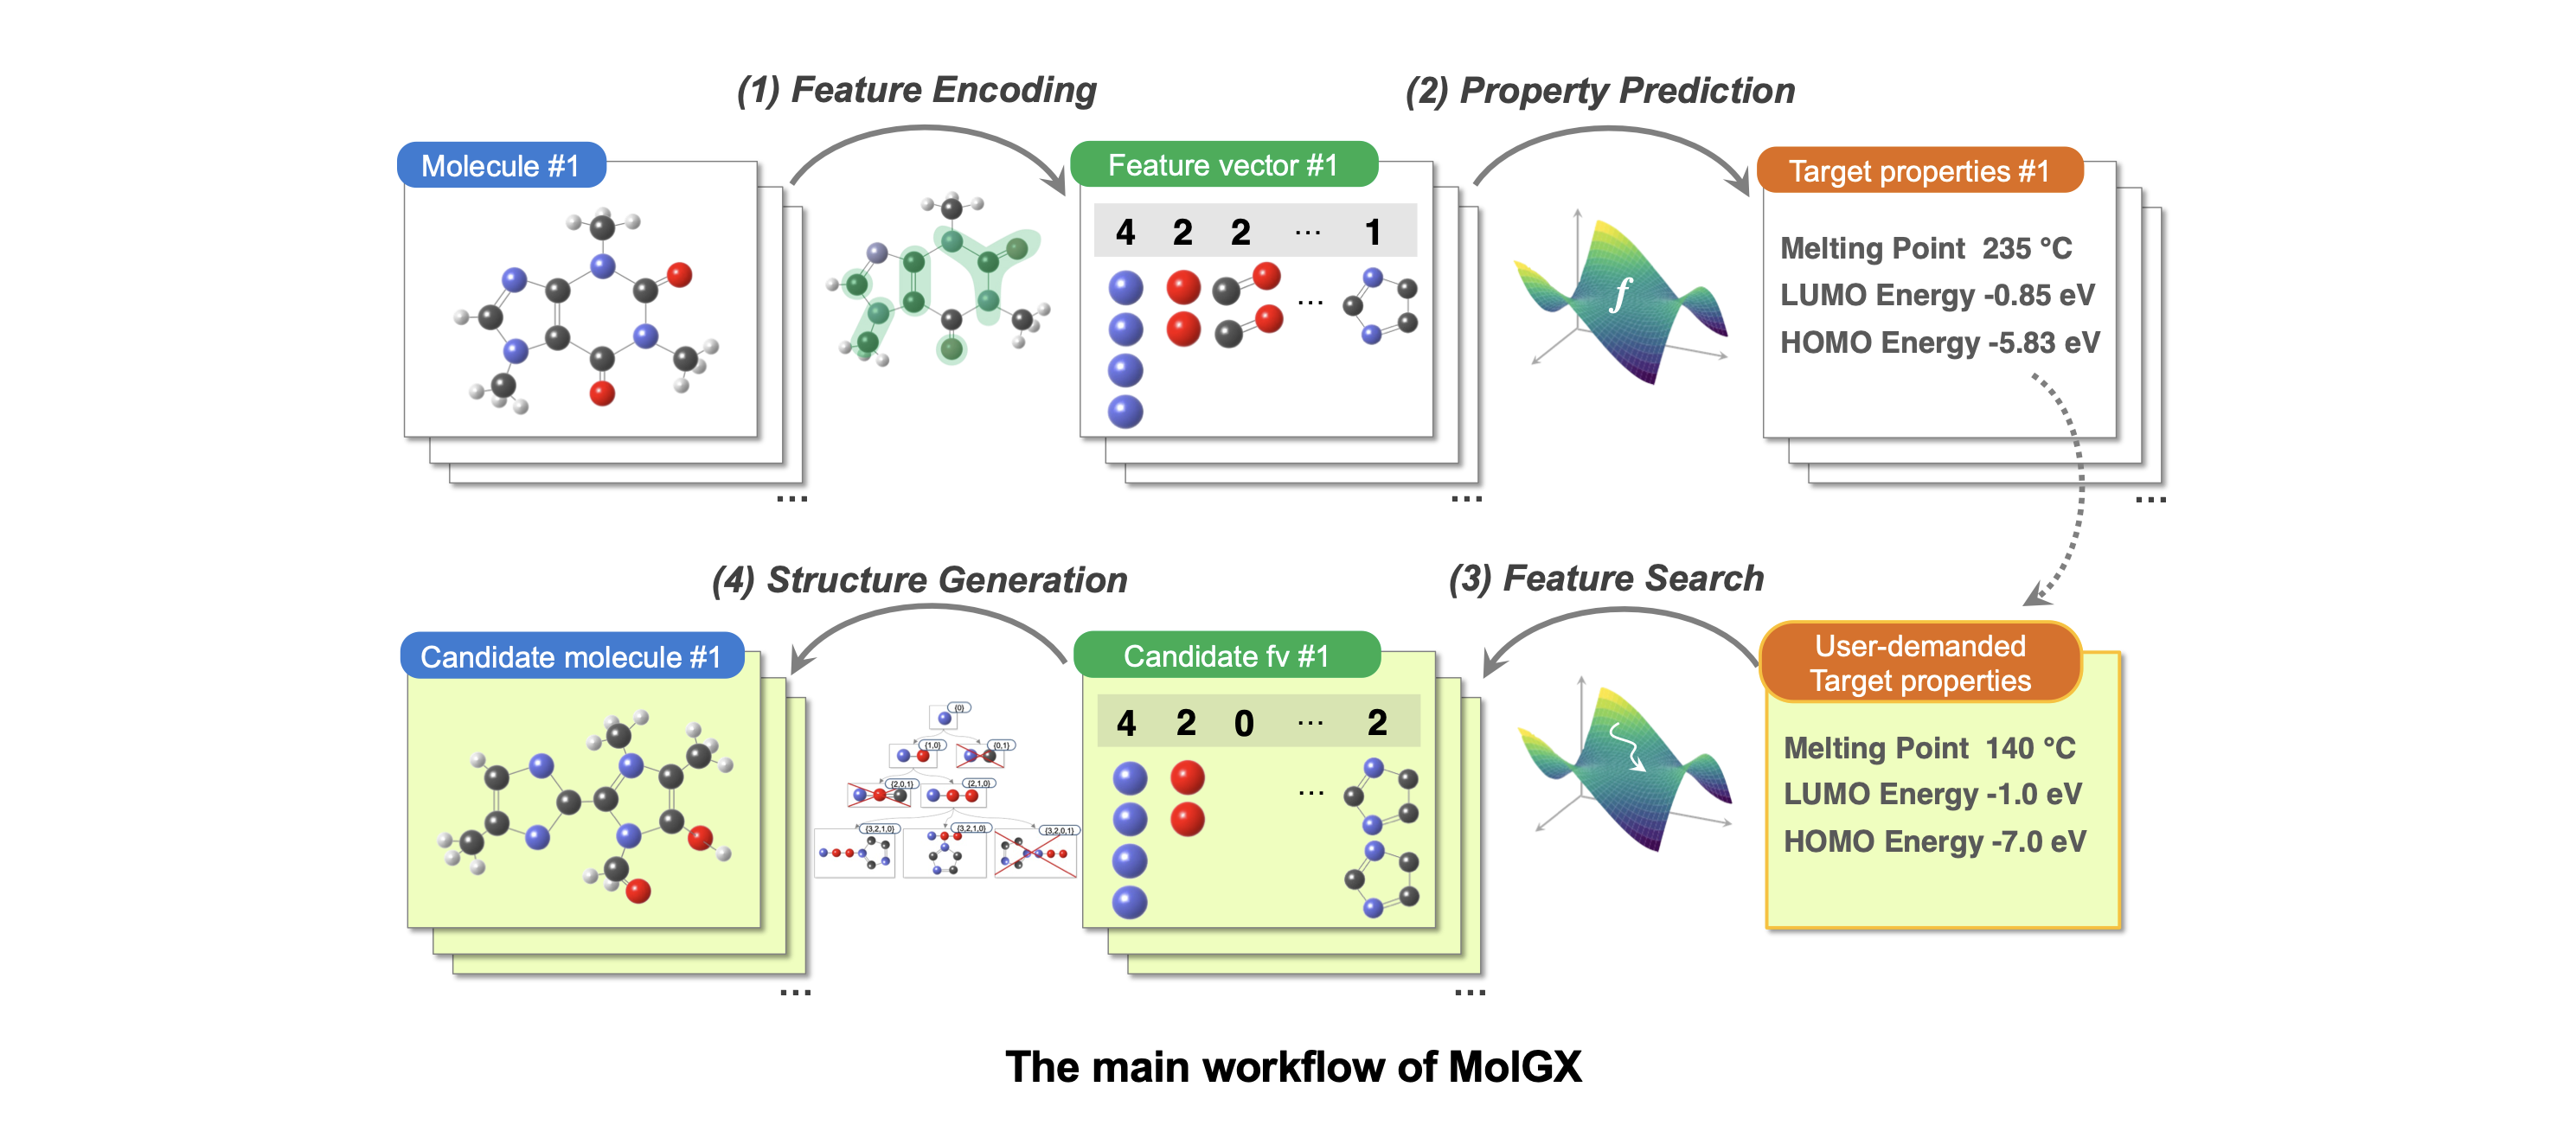

In [1]:
from rdkit import RDLogger
from IPython.display import HTML
from molgx import *

In [2]:
# logger configuration
# logging.basicConfig(level=logging.DEBUG)
# logging.basicConfig(level=logging.INFO)
logging.basicConfig()

In [3]:
# Supress RDKit logger message
RDLogger.DisableLog('rdApp.*')
# Suppress warnings of Python library
import warnings
warnings.filterwarnings('ignore')

## (0) Data Preparation

All material data (chemical strucuture, properties, feature vectors etc) are stored in an instance of <font color="Coral">DataBox.MolData</font>. You can apply important operations to the data through this python object.

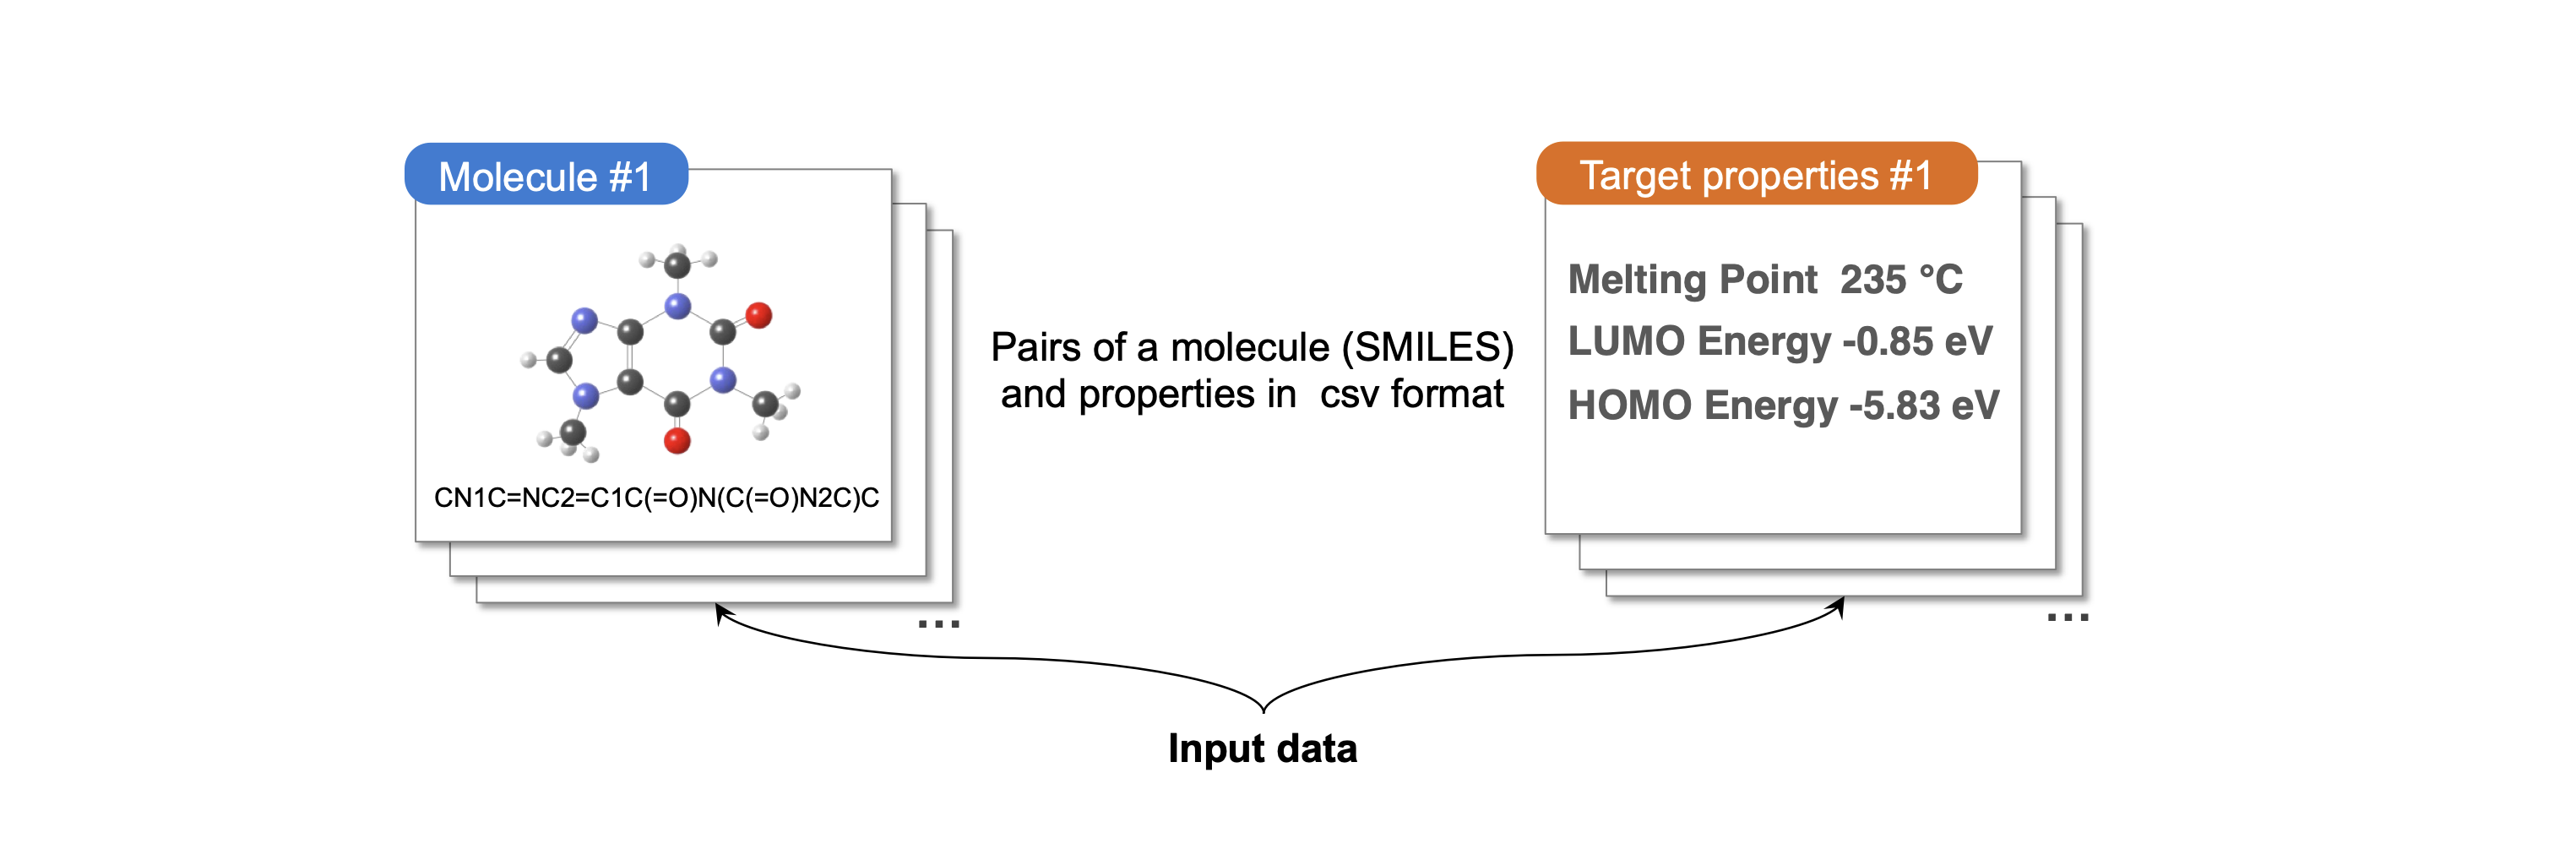

### (0) Data Preparation: from CSV File

The easiest way to prepare data for MolGX is to create <font color="Coral">MolData</font> object from a csv file.   
A sample csv file is in example/sample_data/QM9_partial_500.csv. This data is extracted from part of the [QM9 Dataset](http://quantum-machine.org/datasets/) [1, 2]. The first column is the id of a molecule. Additionally, there should be a column named 'SMILES' or 'SMARTS' which specifies molecular structure (different column names can be specified by optional arguments <font color="Blue">smiles_col</font> and <font color="Blue">smarts_col</font>). The other columns are automatically regarded as properties of a molecule.  
  
[1] L. Ruddigkeit, R. van Deursen, L. C. Blum, J.-L. Reymond, Enumeration of 166 billion organic small molecules in the chemical universe database GDB-17, J. Chem. Inf. Model. 52, 2864–2875, 2012.  
[2] R. Ramakrishnan, P. O. Dral, M. Rupp, O. A. von Lilienfeld, Quantum chemistry structures and properties of 134 kilo molecules, Scientific Data 1, 140022, 2014.

In [4]:
# create an instance of MolData from CSV file
moldata = MolData.read_csv('../sample_data/QM9_partial_500.csv')

You can check properties loaded in `moldata`.

In [5]:
# print properties stored in moldata
moldata.print_properties()

properties:['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']


The <font color="Blue">MolData.get_dataframe()</font> method returns the contents of `moldata` in pandas <font color="Coral">DataFrame</font> format. 

In [6]:
# get smiles and properties in dataframe
df = moldata.get_dataframe(mols=True, smiles=True, property=True)
df

ROMol  \
QM9[67509]   <rdkit.Chem.rdchem.Mol object at 0x738e42f80510>   
QM9[108872]  <rdkit.Chem.rdchem.Mol object at 0x738e42f804a0>   
QM9[60194]   <rdkit.Chem.rdchem.Mol object at 0x738e42f807b0>   
QM9[49022]   <rdkit.Chem.rdchem.Mol object at 0x738e42f80820>   
QM9[32264]   <rdkit.Chem.rdchem.Mol object at 0x738e42f80890>   
...                                                       ...   
QM9[43037]   <rdkit.Chem.rdchem.Mol object at 0x738e42ece110>   
QM9[1275]    <rdkit.Chem.rdchem.Mol object at 0x738e42ece180>   
QM9[90385]   <rdkit.Chem.rdchem.Mol object at 0x738e42ece1f0>   
QM9[70435]   <rdkit.Chem.rdchem.Mol object at 0x738e42ece260>   
QM9[4068]    <rdkit.Chem.rdchem.Mol object at 0x738e42ece2d0>   

                                           SMILES      mu  alpha    homo  \
QM9[67509]        C[C@]12[C@H]3N[C@H]3[C@H]1N2C=O  5.2798  73.82 -0.2305   
QM9[108872]                   CCC1=C[C@@H](O)CCC1  1.9575  88.79 -0.2327   
QM9[60194]               C#C[C@@H]1CN1C[C@@H](C)O  1.7782   82.7 -0.2277   
QM9[49022]        O=C[C@]12CO[C@H]1[C@H]1N[C@H]12   1.115  68.75 -0.2427   
QM9[32264]                            COc1nccnc1O  0.4965  72.96 -0.2233   
...                                           ...     ...    ...     ...   
QM9[43037]   N#C[C@@]12C(=O)[C@H]3N[C@@H]1[C@H]32  6.0601  68.15 -0.2531   
QM9[1275]                              CCCCC(C)=O  2.5767  68.54 -0.2413   
QM9[90385]      C[C@H]1C[C@H]2[C@@H](C#N)[C@@]12O  3.2358  76.29 -0.2654   
QM9[70435]                 O[C@]12C[C@H]1NC21COC1  2.5502  71.18 -0.2176   
QM9[4068]                           COC1CC(=NO)C1  1.3596  69.84 -0.2423   

               lumo     gap         r2      zpve          U0           U  \
QM9[67509]   0.0309  0.2614  1008.3326  0.134871 -417.927046 -417.919185   
QM9[108872]  0.0181  0.2508  1477.7566  0.206613 -388.317515 -388.307953   
QM9[60194]   0.0345  0.2622  1483.6619   0.16791 -403.079304 -403.069239   
QM9[49022]  -0.0371  0.2056   969.9114  0.124251  -437.80444 -437.797236   
QM9[32264]  -0.0311  0.1923  1095.1801  0.114176  -454.00044 -453.992783   
...             ...     ...        ...       ...         ...         ...   
QM9[43037]  -0.0269  0.2262   956.0456  0.090067 -415.555544  -415.54875   
QM9[1275]   -0.0069  0.2344  1271.3575  0.168818 -310.954514 -310.945247   
QM9[90385]   0.0289  0.2943  1077.1528  0.146993 -401.935357 -401.926621   
QM9[70435]    0.056  0.2736  1040.0929  0.147339 -438.999946 -438.991944   
QM9[4068]    0.0063  0.2485  1260.0502   0.14004   -400.9337 -400.925175   

                      H           G      Cv  
QM9[67509]  -417.918241 -417.959154  30.387  
QM9[108872] -388.307009 -388.351988  36.567  
QM9[60194]  -403.068294 -403.114534    37.3  
QM9[49022]  -437.796292 -437.836208  27.782  
QM9[32264]  -453.991839  -454.03274  28.465  
...                 ...         ...     ...  
QM9[43037]  -415.547806   -415.5869  25.931  
QM9[1275]   -310.944303 -310.989533   31.44  
QM9[90385]  -401.925677 -401.968339  33.161  
QM9[70435]     -438.991  -439.03251  31.033  
QM9[4068]   -400.924231  -400.96708  30.669  

[500 rows x 14 columns]

The <font color="Blue">MolData.draw_molecule()</font> static method draws molecules. 

A <font color="Coral">Mol</font> object of RDKit is wrapped in a <font color="Coral">SimpleMolecule</font> object in MolGX. Please note that the <font color="Coral">Mol</font> object is different from the <font color="Coral">SimpleMolecule</font> object. If you need an <font color="Coral">Mol</font> object, you can get it from its corresponding <font color="Coral">SimpleMolecule</font> object with the <font color="Blue">Molecule.get_mol()</font> method. 

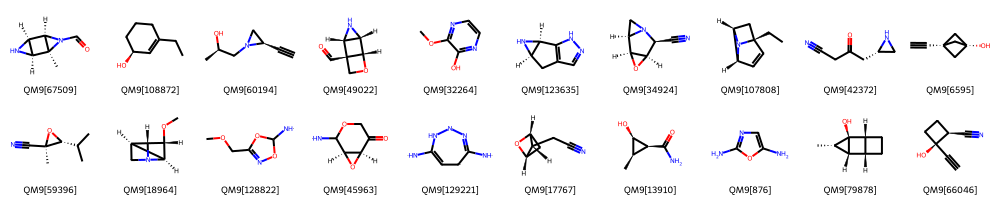

In [7]:
# get a list of molecules stored in moldata
molecules = moldata.get_mols()
# get images of molecules
MolData.draw_molecules(molecules, max_draw=20)

### (1) Masking Unnecessary Molecules 

You can mask molecules to exclude from the model development by setting a mask with the <font color='Blue'>Moldata.set_mols_mask()</font>. A mask is easily generated by a filtering function of dataframe, and a dataframe without masked molecules is obtained by specifying an optional parameter ``with_mask=True`` in the <font color='Blue'>MolData.get_dataframe()</font> method.

In [8]:
# generate a mask molecules whose property 'mu' is less than 5.0, and set it to a moldata.
df = moldata.get_dataframe(property=True)
moldata.set_mols_mask(df['mu'] > 5.0)

# get a dataframe with masked molecules hidden by option 'widh_mask=True'
df = moldata.get_dataframe(mols=True, smiles=True, property=True, with_mask=True)
df

ROMol  \
QM9[67509]   <rdkit.Chem.rdchem.Mol object at 0x738e42ecf680>   
QM9[42372]   <rdkit.Chem.rdchem.Mol object at 0x738e42e482e0>   
QM9[4733]    <rdkit.Chem.rdchem.Mol object at 0x738e42e49fc0>   
QM9[64716]   <rdkit.Chem.rdchem.Mol object at 0x738e42e4a1f0>   
QM9[49288]   <rdkit.Chem.rdchem.Mol object at 0x738e42e4a7a0>   
QM9[100626]  <rdkit.Chem.rdchem.Mol object at 0x738e42e4ac70>   
QM9[127226]  <rdkit.Chem.rdchem.Mol object at 0x738e42e4b140>   
QM9[20560]   <rdkit.Chem.rdchem.Mol object at 0x738e42e4b3e0>   
QM9[57002]   <rdkit.Chem.rdchem.Mol object at 0x738e42e4b610>   
QM9[125630]  <rdkit.Chem.rdchem.Mol object at 0x738e42e4b840>   
QM9[63785]   <rdkit.Chem.rdchem.Mol object at 0x738e42e4b8b0>   
QM9[94641]   <rdkit.Chem.rdchem.Mol object at 0x738e42e4bb50>   
QM9[25880]   <rdkit.Chem.rdchem.Mol object at 0x738e42e4be60>   
QM9[73893]   <rdkit.Chem.rdchem.Mol object at 0x738e42e249e0>   
QM9[30402]   <rdkit.Chem.rdchem.Mol object at 0x738e42e24eb0>   
QM9[79479]   <rdkit.Chem.rdchem.Mol object at 0x738e42e25230>   
QM9[26811]   <rdkit.Chem.rdchem.Mol object at 0x738e42e255b0>   
QM9[24816]   <rdkit.Chem.rdchem.Mol object at 0x738e42e25620>   
QM9[29737]   <rdkit.Chem.rdchem.Mol object at 0x738e42e25af0>   
QM9[57135]   <rdkit.Chem.rdchem.Mol object at 0x738e42e26650>   
QM9[131482]  <rdkit.Chem.rdchem.Mol object at 0x738e42e26ce0>   
QM9[42638]   <rdkit.Chem.rdchem.Mol object at 0x738e42e27300>   
QM9[118448]  <rdkit.Chem.rdchem.Mol object at 0x738e42e274c0>   
QM9[130418]  <rdkit.Chem.rdchem.Mol object at 0x738e42e20820>   
QM9[46495]   <rdkit.Chem.rdchem.Mol object at 0x738e42e20c80>   
QM9[123369]  <rdkit.Chem.rdchem.Mol object at 0x738e42e20f90>   
QM9[6196]    <rdkit.Chem.rdchem.Mol object at 0x738e42e21460>   
QM9[29870]   <rdkit.Chem.rdchem.Mol object at 0x738e42e21620>   
QM9[34259]   <rdkit.Chem.rdchem.Mol object at 0x738e42e21d20>   
QM9[127359]  <rdkit.Chem.rdchem.Mol object at 0x738e42e22260>   
QM9[131748]  <rdkit.Chem.rdchem.Mol object at 0x738e42e226c0>   
QM9[7792]    <rdkit.Chem.rdchem.Mol object at 0x738e42e22730>   
QM9[48490]   <rdkit.Chem.rdchem.Mol object at 0x738e42e22880>   
QM9[123901]  <rdkit.Chem.rdchem.Mol object at 0x738e42e23140>   
QM9[73760]   <rdkit.Chem.rdchem.Mol object at 0x738e42e236f0>   
QM9[6063]    <rdkit.Chem.rdchem.Mol object at 0x738e42e23920>   
QM9[121507]  <rdkit.Chem.rdchem.Mol object at 0x738e42e1c820>   
QM9[130019]  <rdkit.Chem.rdchem.Mol object at 0x738e42e1c890>   
QM9[15506]   <rdkit.Chem.rdchem.Mol object at 0x738e42e1c900>   
QM9[10718]   <rdkit.Chem.rdchem.Mol object at 0x738e42e1dfc0>   
QM9[47027]   <rdkit.Chem.rdchem.Mol object at 0x738e42e1e110>   
QM9[34525]   <rdkit.Chem.rdchem.Mol object at 0x738e42e1e260>   
QM9[43037]   <rdkit.Chem.rdchem.Mol object at 0x738e42e1e2d0>   

                                            SMILES       mu  alpha    homo  \
QM9[67509]         C[C@]12[C@H]3N[C@H]3[C@H]1N2C=O   5.2798  73.82 -0.2305   
QM9[42372]                     N#CCC(=O)C[C@H]1CN1   6.0532  73.86 -0.2674   
QM9[4733]                            N#Cc1nc(N)co1   5.5698  62.84 -0.2308   
QM9[64716]            C[C@@]1(CC#N)O[C@H]2C[C@H]21   5.2192  75.64 -0.2518   
QM9[49288]                O=CC1=CNC[C@H]2N[C@@H]12   5.7271  80.26  -0.205   
QM9[100626]                        N.N#CC(C#N)=CCN   6.8675  82.21 -0.2678   
QM9[127226]                         Cc1cn(C)nc1C#N   6.5801   80.1 -0.2534   
QM9[20560]                    C[C@@H](N)c1cnn[nH]1   5.6371  66.18  -0.246   
QM9[57002]       N#C[C@H](O)[C@H]1N[C@H]2C[C@@H]12   5.0848  72.08 -0.2442   
QM9[125630]                     CC1=NC(NC=N)=N[N]1  11.1783  88.47 -0.1831   
QM9[63785]              CC1(C)N[C@H]2C(=O)O[C@H]21   5.0078  71.52 -0.2394   
QM9[94641]                  N#CCN[C@@H]1CC[C@@H]1O   5.6063  77.12 -0.2335   
QM9[25880]                     Cc1cc(C(N)=O)c[nH]1   5.2621   78.7 -0.2109   
QM9[73893]               NC1=C(C=O)[C@H]2N[C@H]2C1   5.2084  79.46 -0.2096   
QM9[30402]               

Setting the mask to``None`` resets the mask of molecules. 

In [9]:
# clear mask of the molecule
moldata.set_mols_mask(None)

## (1) Feature Encoding

Features of a molecule are extracted by <font color="Coral">FeatureExtractor</font>. There are two types of feature extractors: 
* <font color="Coral">FeatureExtractor</font> extracts features from a molecule, based on structural information.
* <font color="Coral">FeatureOperator</font> is a subclass of FeatureExtractor and extracts features from other features already extracted by a feature extractor.

<font color="Blue">print_feature_extractor()</font> displays a list of available feature extractors in the <font color="Coral">FeatureExtraction</font> module.  

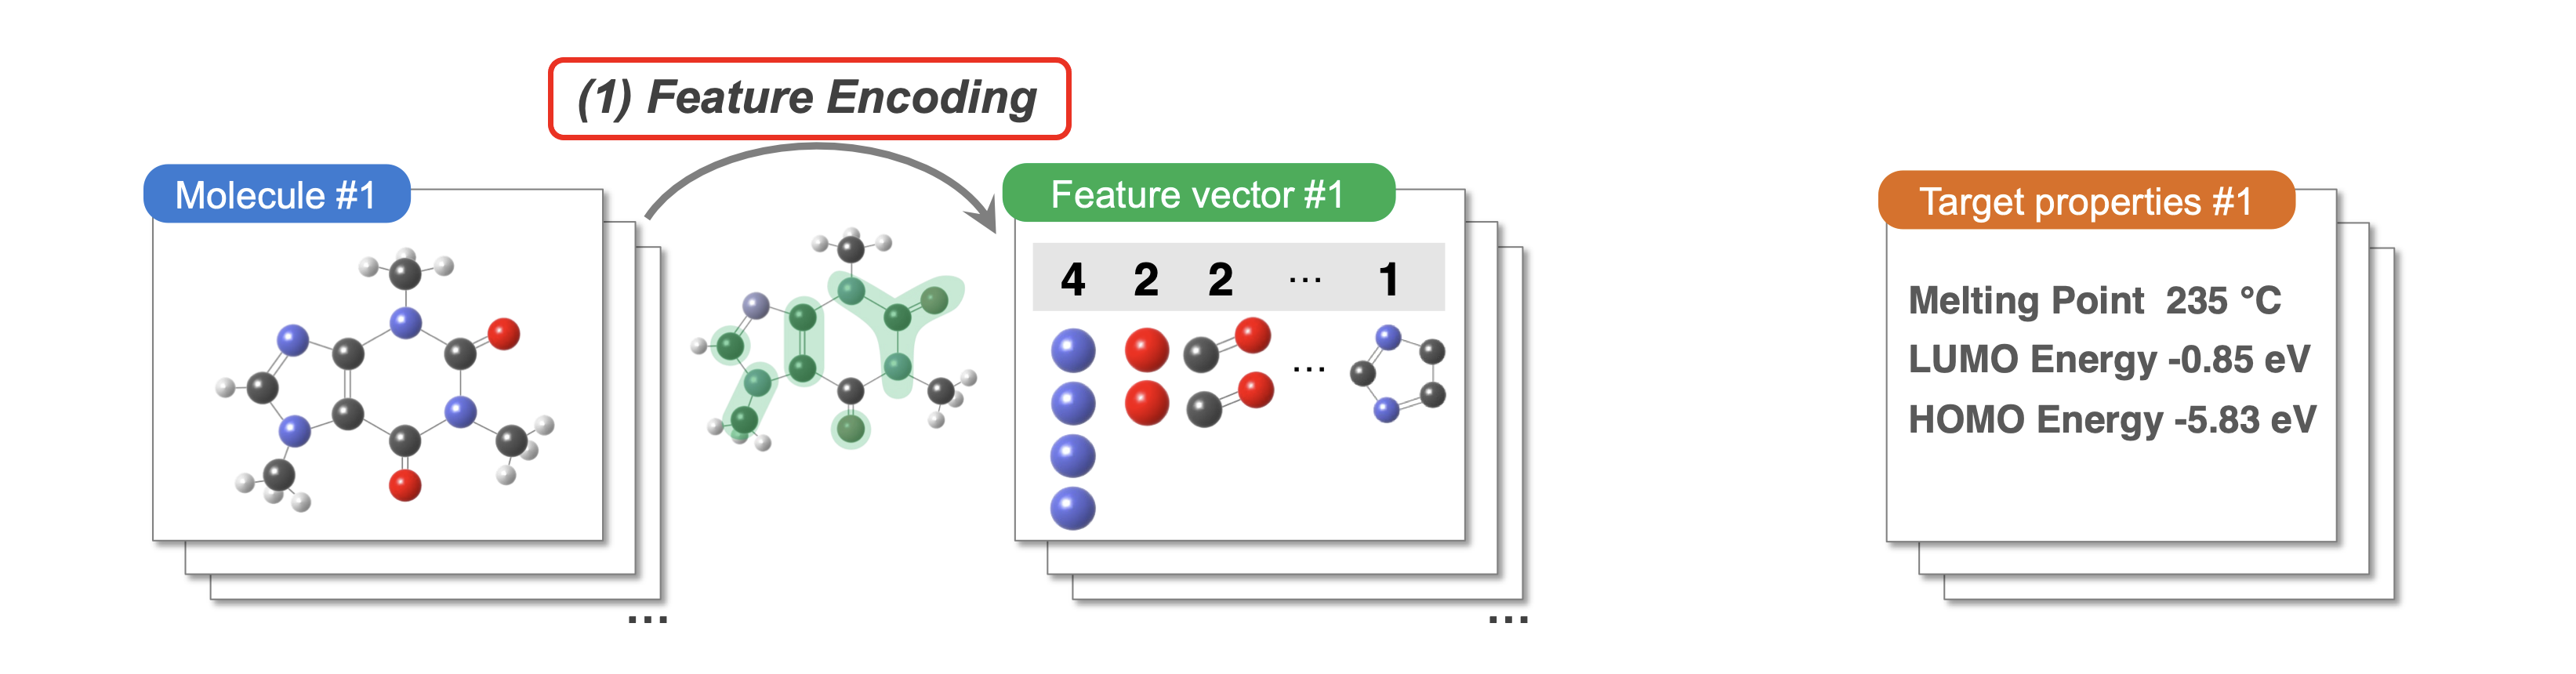

In [10]:
# print all the available feature extractors
print_feature_extractor()

Available feature extractors:
0: HeavyAtomExtractor
1: RingExtractor
2: AromaticRingExtractor
3: FingerPrintStructureExtractor
4: FeatureSumOperator


You can apply these feature extractors and feature operators to a molecules in a moldata object by using the <font color="Blue">MolData.extract_features()</font> method. 

### (1) Feature Encoding - Heavy Atom

<font color="Coral">HeavyAtomExtractor</font> counts the number of atoms for each heavy atom in each molecule. After features are extracted, you will get a <font color="Coral">FeatureSet</font> object. The <font color="Blue">print_feature()</font> displays its contents. 

In [11]:
# extract the number of heavy atoms in molecules
fs_atom = moldata.extract_features(HeavyAtomExtractor(moldata))
fs_atom.print_features()

heavy_atom:['atom:C', 'atom:F', 'atom:N', 'atom:O']


<font color="Coral">FeatureExtractor</font> extracts all the features and save their properties in each <font color="Coral">Molecule</font> object. <font color="Blue">MolData.print_mol_info()</font> or <font color="Blue">MolData.print_mol_info_by_index()</font> with a molecule id or a molecule index, repectively can print information on its corresponding molecule. 

In [12]:
# print information on the 10-th molecule in moldata
moldata.print_mol_info_by_index(3)

Molecule: id=QM9[49022] SMILES=O=C[C@]12CO[C@H]1[C@H]1N[C@H]12 SMARTS=[#8]=[#6]-[#6@]12-[#6]-[#8]-[#6@H]-1-[#6@H]1-[#7]-[#6@@H]-2-1
Properties:
  {'mu': 1.115, 'alpha': 68.75, 'homo': -0.2427, 'lumo': -0.0371, 'gap': 0.2056, 'r2': 969.9114, 'zpve': 0.124251, 'U0': -437.80444, 'U': -437.797236, 'H': -437.796292, 'G': -437.836208, 'Cv': 27.782}
FeatureSet:heavy_atom
  {'atom:C': 6, 'atom:N': 1, 'atom:O': 2}


### (2) Feature Encoding - Ring

<font color="Coral">RingExtractor</font> counts the number of rings of each size in a molecule.

In [13]:
# extract the number of rings in molecules
fs_ring = moldata.extract_features(RingExtractor(moldata))
fs_ring.print_features()

ring:['ring:3', 'ring:4', 'ring:5', 'ring:6', 'ring:7']


You will see that 'FeatureSet:ring' is added to a molecule after applying RingExtractor.

In [14]:
# print information on the 10-th molecule in moldata, features on rings are added to the molecule
moldata.print_mol_info_by_index(3)

Molecule: id=QM9[49022] SMILES=O=C[C@]12CO[C@H]1[C@H]1N[C@H]12 SMARTS=[#8]=[#6]-[#6@]12-[#6]-[#8]-[#6@H]-1-[#6@H]1-[#7]-[#6@@H]-2-1
Properties:
  {'mu': 1.115, 'alpha': 68.75, 'homo': -0.2427, 'lumo': -0.0371, 'gap': 0.2056, 'r2': 969.9114, 'zpve': 0.124251, 'U0': -437.80444, 'U': -437.797236, 'H': -437.796292, 'G': -437.836208, 'Cv': 27.782}
FeatureSet:heavy_atom
  {'atom:C': 6, 'atom:N': 1, 'atom:O': 2}
FeatureSet:ring
  {'ring:3': 1, 'ring:4': 2}


### (3) Feature Encoding - Aromatic Ring

<font color="Coral">AromaticRingExtractor</font> counts the number of aromatic rings of each size in a molecule.

In [15]:
# extract the number of aromatic rings in molecules
fs_aring = moldata.extract_features(AromaticRingExtractor(moldata))
fs_aring.print_features()

aromatic_ring:['aring:5', 'aring:6', 'aring:7']


### (4) Feature Encoding - Fingerprint Structure

<font color="Coral">FingerPrintStructureExtractor</font> counts the number of fingerprint structures within a given radius. The radius is specified by a parameter ``radius=`` of a constructor of FingerPrintStructureExtractor. This fingerprint sturcture is quite different from the substructure decribed above. The fingerprint structure is a subgraph spanning from a specific atom (root atom) within the radius.

The number of the occurrences of each fingerprint structure is counted by matching a root atom to each atom in a molecule, and the number of bonds and connecting atoms must be exactly matched. Therefore, the total number of the occurrences of fingerprint structures of a molecule is the same as the number of heavy atoms in a molecule. On the other hand, the number of the occurrences of the substructures are counted simply as a subgraph of a molecular structure.

In [16]:
# extract fingerprint structure of radus 1
fs_fp_structure1 = moldata.extract_features(FingerPrintStructureExtractor(moldata, radius=1))
fs_fp_structure1.print_features()

finger_print_structure:radius=1:['fp:r1[C]:*#C', 'fp:r1[C]:*C', 'fp:r1[C]:*N', 'fp:r1[C]:*O', 'fp:r1[C]:C#*C', 'fp:r1[C]:C*#N', 'fp:r1[C]:C*(=N)N', 'fp:r1[C]:C*(=N)O', 'fp:r1[C]:C*(=O)O', 'fp:r1[C]:C*(C)(C)C', 'fp:r1[C]:C*(C)(C)N', 'fp:r1[C]:C*(C)(C)O', 'fp:r1[C]:C*(C)(O)O', 'fp:r1[C]:C*(C)=N', 'fp:r1[C]:C*(C)=O', 'fp:r1[C]:C*(C)C', 'fp:r1[C]:C*(C)N', 'fp:r1[C]:C*(C)O', 'fp:r1[C]:C*(N)=O', 'fp:r1[C]:C*(N)N', 'fp:r1[C]:C*(N)O', 'fp:r1[C]:C*(O)F', 'fp:r1[C]:C*(O)O', 'fp:r1[C]:C*=N', 'fp:r1[C]:C*=O', 'fp:r1[C]:C*C', 'fp:r1[C]:C*N', 'fp:r1[C]:C*O', 'fp:r1[C]:C=*(C)C', 'fp:r1[C]:C=*(C)N', 'fp:r1[C]:C=*(C)O', 'fp:r1[C]:C=*(N)N', 'fp:r1[C]:C=*(N)O', 'fp:r1[C]:C=*C', 'fp:r1[C]:C=*N', 'fp:r1[C]:C=*O', 'fp:r1[C]:N*(=O)O', 'fp:r1[C]:N*(N)=O', 'fp:r1[C]:N*(N)O', 'fp:r1[C]:N*(O)O', 'fp:r1[C]:N*=O', 'fp:r1[C]:N*N', 'fp:r1[C]:N*O', 'fp:r1[C]:N=*(N)N', 'fp:r1[C]:N=*(N)O', 'fp:r1[C]:N=*N', 'fp:r1[C]:N=*O', 'fp:r1[C]:O*O', 'fp:r1[C]:O=*(O)O', 'fp:r1[C]:O=*=O', 'fp:r1[C]:O=*O', 'fp:r1[F]:*C', 'fp:r1[N]:*

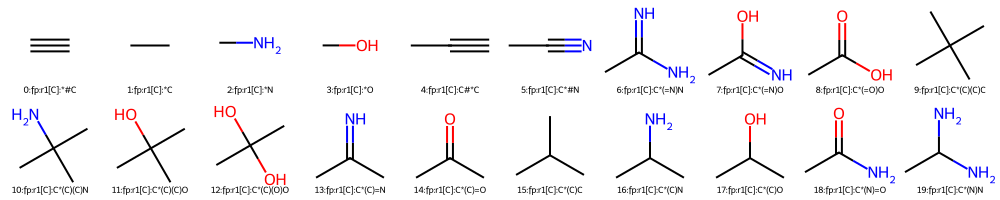

In [17]:
# draw extracted fingerprint structures of radius 1
MolData.draw_features(fs_fp_structure1, max_draw=20)

You can extract fingerprint structures of radius larger than 1. However, the number of extracted structures usually becomes quite huge. So extracting fingerprint structure of radius=1 might be feasible for feature development. 

In [18]:
# extract fingerprint structure of radus 2
fs_fp_structure2 = moldata.extract_features(FingerPrintStructureExtractor(moldata, radius=2))
# fs_fp_structure1.print_features() --- too many for print all

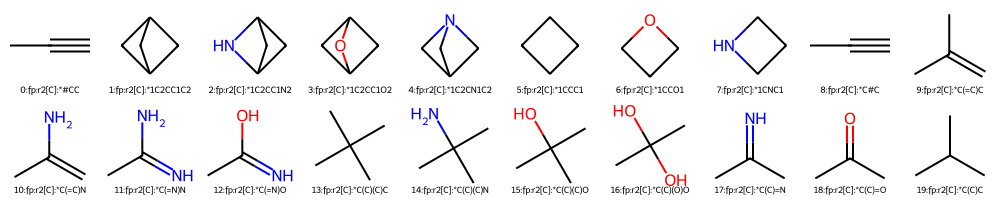

In [19]:
# draw extracted fingerprint structures of radius 2
MolData.draw_features(fs_fp_structure2, max_draw=20)

### (5) Feature Operation: Sum of Feature Values

A feature oprator applies an operation on the extracted feature values. <font color="Coral">FeatureSumOperator</font> takes a sum of feature values in a feature set. For example, <font color="Coral">HeavyAtomExtractor</font> counts the number of individual atoms. You can get the total number of atoms by applying <font color="Coral">FeatureSumOperator</font>, after the number of individual atoms is extracted. 

A constructor of <font color="Coral">FeatureOperator</font> takes a feature set object as an argument in addition to a moldata object. But you can apply the feature operator by using <font color="Blue">MolData.extract_features()</font> in the same way as <font color="Coral">FeatureExtractor</font>.

In [20]:
# extract the total number of atoms from heavy atom count
fs_atom_sum = moldata.extract_features(FeatureSumOperator(moldata, fs_atom))
fs_atom_sum.print_features()

heavy_atom:sum():['atom:sum']


In [21]:
# check the result of sum operation
moldata.get_dataframe(features=[fs_atom_sum, fs_atom])[:5]

atom:sum  atom:C  atom:F  atom:N  atom:O
QM9[67509]          9       6       0       2       1
QM9[108872]         9       8       0       0       1
QM9[60194]          9       7       0       1       1
QM9[49022]          9       6       0       1       2
QM9[32264]          9       5       0       2       2

## (2) Preparation of Feature Vectors

So far, we have extracted several features with individual feature extractors. All the extracted features are stored in moldata, and you can display them with the <font color="Blue">MolData.print_features()</font> method. You can also get the <font color="Coral">FeatureSet</font> object by using <font color="Blue">MolData.get_features()</font> with the id, or <font color="Blue">MolData.get_features_by_index()</font> from the index of features in the printed list.

In [22]:
# print extracted features
moldata.print_features()

feature set list:
  0: heavy_atom
  1: ring
  2: aromatic_ring
  3: finger_print_structure:radius=1
  4: finger_print_structure:radius=2
  5: heavy_atom:sum()


In [23]:
# get FeatureSet object by feature set id
fs_atom = moldata.get_features('heavy_atom')
fs_atom.print_features()
# get FeatureSet object by the index in a feature set list
fs_ring = moldata.get_features_by_index(1)
fs_ring.print_features()

heavy_atom:['atom:C', 'atom:F', 'atom:N', 'atom:O']
ring:['ring:3', 'ring:4', 'ring:5', 'ring:6', 'ring:7']


### (1) Merging Feature Sets

Each feature set is not often expressive enough for accurate prediction of a property. You can combine several feature sets, and obtain a richer feature vector by using <font color="Blue">MolData.merge_features()</font> or <font color="Blue">MolData.merge_features_by_index()</font>.

In [24]:
# merge feature sets of "fp-structure of raidius 1"
# fs_fp_all = moldata.merge_features_by_index([6])
fs_fp_all = moldata.merge_features([fs_fp_structure1.id])

# merge feature sets of "heavy atom", "ring", "aromatic ring", and "fp-structure of raidus 1"
# features_fp = moldata.merge_features_by_index([0,1,2,6])
features_fp = moldata.merge_features([fs_atom.id, fs_ring.id, fs_aring.id, fs_fp_structure1.id])

In [25]:
# check the contents of mergered feature set
features_fp.print_features()

|aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|:['aring:5', 'aring:6', 'aring:7', 'fp:r1[C]:*#C', 'fp:r1[C]:*C', 'fp:r1[C]:*N', 'fp:r1[C]:*O', 'fp:r1[C]:C#*C', 'fp:r1[C]:C*#N', 'fp:r1[C]:C*(=N)N', 'fp:r1[C]:C*(=N)O', 'fp:r1[C]:C*(=O)O', 'fp:r1[C]:C*(C)(C)C', 'fp:r1[C]:C*(C)(C)N', 'fp:r1[C]:C*(C)(C)O', 'fp:r1[C]:C*(C)(O)O', 'fp:r1[C]:C*(C)=N', 'fp:r1[C]:C*(C)=O', 'fp:r1[C]:C*(C)C', 'fp:r1[C]:C*(C)N', 'fp:r1[C]:C*(C)O', 'fp:r1[C]:C*(N)=O', 'fp:r1[C]:C*(N)N', 'fp:r1[C]:C*(N)O', 'fp:r1[C]:C*(O)F', 'fp:r1[C]:C*(O)O', 'fp:r1[C]:C*=N', 'fp:r1[C]:C*=O', 'fp:r1[C]:C*C', 'fp:r1[C]:C*N', 'fp:r1[C]:C*O', 'fp:r1[C]:C=*(C)C', 'fp:r1[C]:C=*(C)N', 'fp:r1[C]:C=*(C)O', 'fp:r1[C]:C=*(N)N', 'fp:r1[C]:C=*(N)O', 'fp:r1[C]:C=*C', 'fp:r1[C]:C=*N', 'fp:r1[C]:C=*O', 'fp:r1[C]:N*(=O)O', 'fp:r1[C]:N*(N)=O', 'fp:r1[C]:N*(N)O', 'fp:r1[C]:N*(O)O', 'fp:r1[C]:N*=O', 'fp:r1[C]:N*N', 'fp:r1[C]:N*O', 'fp:r1[C]:N=*(N)N', 'fp:r1[C]:N=*(N)O', 'fp:r1[C]:N=*N', 'fp:r1[C]:N=*O', 'fp:r1[C]:O*O', 'fp:r1[C]:O=*(O)

Merged feature sets are also stored in `moldata`. <font Color="Blue">MolData.print_merged_features()</font> displays a list of merged feature sets stored there. You can also get a <font color="Coral">MergedFeatureSet</font> object by using <font color="Blue">MolData.get_merged_features()</font> from the id, or  <font color="Blue">MolData.get_merged_features_by_index()</font> from the index of merged features in the printed list.

In [26]:
# print merged features
moldata.print_merged_features()

merged feature set list:
  0: |finger_print_structure:radius=1|
  1: |aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|


In [27]:
# get merged feature sets by the index of merged feature set list printed above
features_1 = moldata.get_merged_features_by_index(1)
features_1.id

'|aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|'

Now you have a more expressive feature vector by merging individual feature sets. The <font color="Blue">MolData.get_dataframe()</font> method returns the contents of the obtained feature vector as a dataframe. You can also save the same data as a csv file with the <font color="Blue">Moldata.write_csv()</font> method.

In [28]:
# get feature vector as dataframe object
moldata.get_dataframe(features=features_fp)

aring:5  aring:6  aring:7  fp:r1[C]:*#C  fp:r1[C]:*C  \
QM9[67509]         0        0        0             0            1   
QM9[108872]        0        0        0             0            1   
QM9[60194]         0        0        0             1            1   
QM9[49022]         0        0        0             0            0   
QM9[32264]         0        1        0             0            0   
...              ...      ...      ...           ...          ...   
QM9[43037]         0        0        0             0            0   
QM9[1275]          0        0        0             0            2   
QM9[90385]         0        0        0             0            1   
QM9[70435]         0        0        0             0            0   
QM9[4068]          0        0        0             0            0   

             fp:r1[C]:*N  fp:r1[C]:*O  fp:r1[C]:C#*C  fp:r1[C]:C*#N  \
QM9[67509]             0            0              0              0   
QM9[108872]            0            0              0              0   
QM9[60194]             0            0              1              0   
QM9[49022]             0            0              0              0   
QM9[32264]             0            1              0              0   
...                  ...          ...            ...            ...   
QM9[43037]             0            0              0              1   
QM9[1275]              0            0              0              0   
QM9[90385]             0            0              0              1   
QM9[70435]             0            0              0              0   
QM9[4068]              0            1              0              0   

             fp:r1[C]:C*(=N)N  ...  fp:r1[o]:n*n  atom:C  atom:F  atom:N  \
QM9[67509]                  0  ...             0       6       0       2   
QM9[108872]                 0  ...             0       8       0       0   
QM9[60194]                  0  ...             0       7       0       1   
QM9[49022]                  0  ...             0       6       0       1   
QM9[32264]                  0  ...             0       5       0       2   
...                       ...  ...           ...     ...     ...     ...   
QM9[43037]                  0  ...             0       6       0       2   
QM9[1275]                   0  ...             0       6       0       0   
QM9[90385]                  0  ...             0       7       0       1   
QM9[70435]                  0  ...             0       6       0       1   
QM9[4068]                   0  ...             0       5       0       1   

             atom:O  ring:3  ring:4  ring:5  ring:6  ring:7  
QM9[67509]        1       2       1       0       0       0  
QM9[108872]       1       0       0       0       1       0  
QM9[60194]        1       1       0       0       0       0  
QM9[49022]        2       1       2       0       0       0  
QM9[32264]        2       0       0       0       1       0  
...             ...     ...     ...     ...     ...     ...  
QM9[43037]        1       1       2       0       0       0  
QM9[1275]         1       0       0       0       0       0  
QM9[90385]        1       1       1       0       0       0  
QM9[70435]        2       1       2       0       0       0  
QM9[4068]         2       0       1       0       0       0  

[500 rows x 121 columns]

In [29]:
# save feature vector in csv file (smiles and properties are also saved by default, so they are disabled by options)
moldata.write_csv('feature_fp.csv', smiles=False, property=False, features=features_fp)

### (2) Visualizing Feature Vector Distribution

<font color="Blue">MolData.plot_distribution()</font> plots high dimensional feature vectors with target property values by mapping a feature vector to a 2d plane, based on the [t-SNE algorithm](https://lvdmaaten.github.io/tsne/). This function is useful to get a rough picture of how well the features describe the target property.

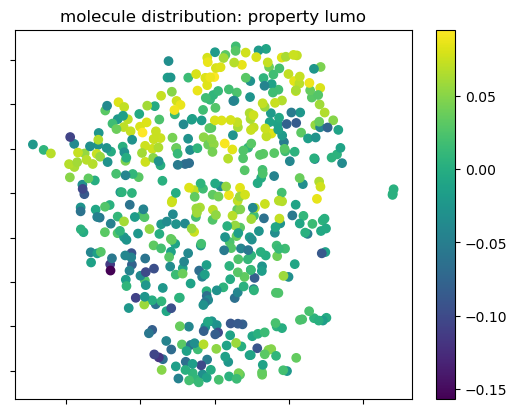

In [30]:
moldata.plot_distribution('lumo', features_fp)

## (3) Prediction

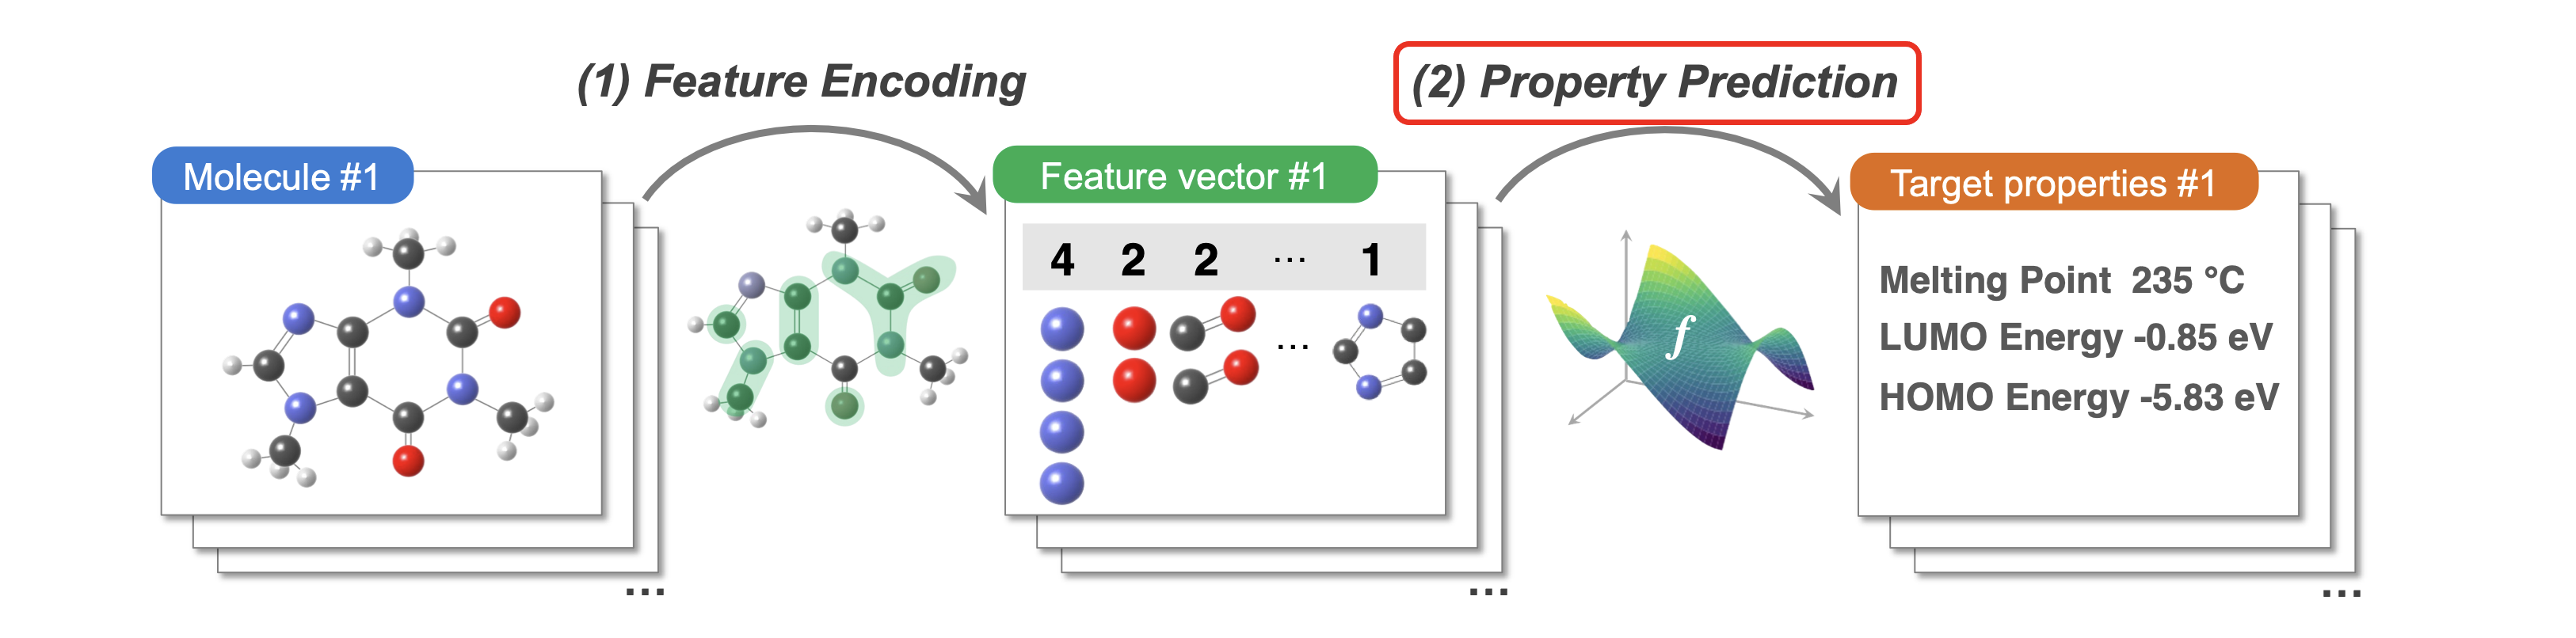

Using feature vector obtained in the previous section, we create a regression model to predict a targeted property. The <font color='Coral'>Prediction</font> module includes regression models to predict a single targeted property with cross validaton. <font color="Blue">print_regression_model()</font> displays a list of available models. An object for a regression model is created by specifying a MolData object, a target property, and a feature set as parameters.

In [31]:
# print all the available regression models
print_regression_model()

Available regression models:
0: LinearRegressionModel
1: RidgeRegressionModel
2: LassoRegressionModel
3: ElasticNetRegressionModel
4: RandomForestRegressionModel


### (1) Linear Models

#### (1-1) Linear Regression Model

<font color="Coral">LinearRegressionModel</font> is implemented by wrapping [LinearRegression](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) of the [scikit-learn](https://scikit-learn.org/stable/index.html) package. It fits a linear model with coefficients $w = (w_1, ..., w_p)$ to minimize the residual sum of squares between the observed targets in the dataset and the targets predicted by the linear approximation. Mathematically, it solves the following form:
    
$$ \min_{w} || X w - y||_2^2 $$

This regression model is the simplest linear regression without any regurlarization terms. So it is not so useful in general, especially when the feature vector size is quite large compared to the size of training data.

In [32]:
# apply regression model to specified target propetry 'lumo'
model = moldata.fit_regression_model(LinearRegressionModel(moldata, 'lumo', features_fp))

regression model cross validation target='lumo': data_size=500: model:LinearRegression n_splits=3 shuffle=True


Let's check the coefficients determined by fitting the model to training data. Some coefficients are very large. Therefore, They are very  sensitive to the training data when the feature vector is very large and sparse.

In [33]:
# get coeeficients of the model
model.get_coef()

array([-1.76039892e-02, -9.36374278e-02, -6.62171370e-02,  2.54866131e-03,
        6.46275127e-03,  1.62771433e-02, -1.12354442e-04, -1.52346843e-02,
       -1.19900353e-04, -6.37513440e-03, -2.77489328e-02, -1.15487609e-02,
       -7.96551878e-03,  1.53125827e-04, -5.92156941e-03, -5.43282371e-03,
       -1.93180574e-02, -3.93706848e-02, -2.55744611e-03,  7.09050156e-03,
       -3.97967268e-05,  2.10563629e-03, -3.37711454e-02, -4.03185694e-02,
       -2.11984258e-02,  2.27044069e-02, -1.43599759e-03, -3.87974622e-02,
        3.59092326e-03,  1.54428369e-02,  5.80672175e-03, -1.87106596e-02,
       -1.73354040e-03,  7.15725123e-02, -1.42529545e-02, -6.14487199e-02,
       -2.24985983e-02, -9.01784025e-03, -4.35206970e-03,  4.52055494e-02,
        3.08094732e-02, -5.59664154e-02,  5.55805193e-02,  2.23610272e-02,
       -5.71869871e-03, -1.76011960e-02,  3.09339537e-02, -1.87733060e-02,
        1.27856621e-02,  2.41091498e-03,  3.28949630e-02,  3.01861273e-02,
        8.10759863e-02,  

<font color="Blue">RegressionModel.predict()</font> returns a dataframe of estimated values. These numbers look good because they are estimated values of the training data.

In [34]:
# get estimate of target property 'mu' in dataframe
model.predict()[:5]

'lumo':LinearRegression:fit
QM9[67509]                      0.027866
QM9[108872]                     0.032416
QM9[60194]                      0.045840
QM9[49022]                     -0.019669
QM9[32264]                     -0.042021

<font color="Blue">RegressionModel.plot_estimate()</font> plots the esimated values on the vertical axis against the real ones on the horizontal axis. In the figure, the R^2 score is also shown in the title line. As you can see, the R^2 score calculated by cross validation is extremely poor while the R^2 score of estimated value is reasonable. 

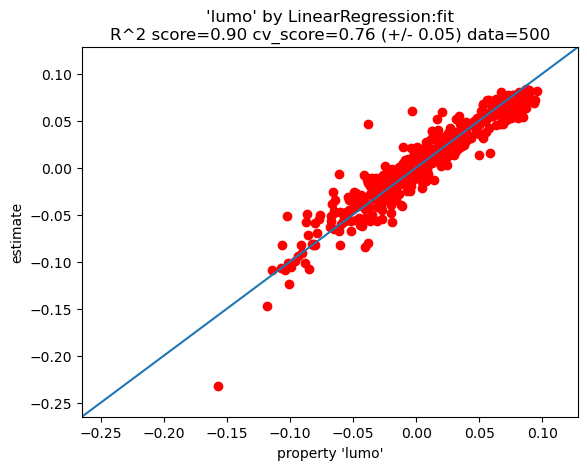

In [35]:
# plot estimate of parget propterty
model.plot_estimate()

#### (1-2) Ridge Regression Model

<font color="Coral">RidgeRegressionModel</font> is implemented by wrapping [Ridge](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) of the [scikit-learn](https://scikit-learn.org/stable/index.html) package. It minimizes the residual sum of squares with an L2 regularization term.

$$ \min_{w} || X w - y||_2^2 + \alpha ||w||_2^2 $$

The model has hyperparameter <font color="Blue">alpha</font> ($\alpha$). As <font color="Blue">alpha</font> increses, the L2 norm of the coefficients decreases. The model tends to be more robust to larger training data and colinearity of the features.

regression model cross validation target='lumo': data_size=500: model:Ridge n_splits=3 shuffle=True


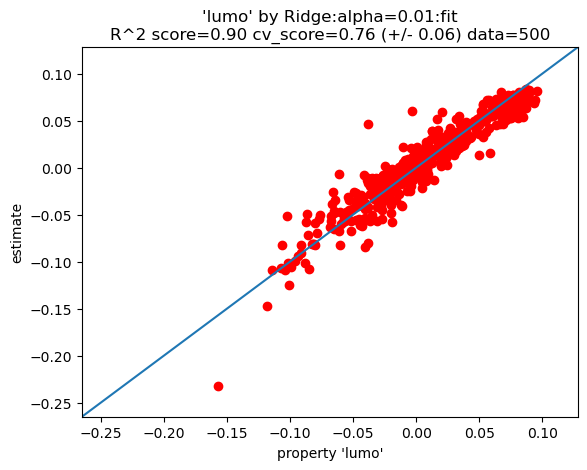

In [36]:
# apply regression model to specified target property 'lumo' with specified hyperparameter 'alpha'
model = moldata.fit_regression_model(RidgeRegressionModel(moldata, 'lumo', features_fp, alpha=0.01))
model.plot_estimate()

You can optimize the hyperparameters for given data by using the <font color="Blue">MolData.optimize_regression_model()</font> method. A grid search invoked in the method finds the best hyperparameters among a list of hyperparameter values. Default candidate values examined by grid search are defined for each regression model, so you do not have to explicitly specify them in most cases.

regression model parameter optimization target='lumo': data_size=500: model:Ridge n_splits=3 shuffle=True
optimized parameters: {'alpha': 10.0}
regression model cross validation target='lumo': data_size=500: model:Ridge n_splits=3 shuffle=True
R^2 score=0.90 cv_score=0.78 (+/- 0.04)


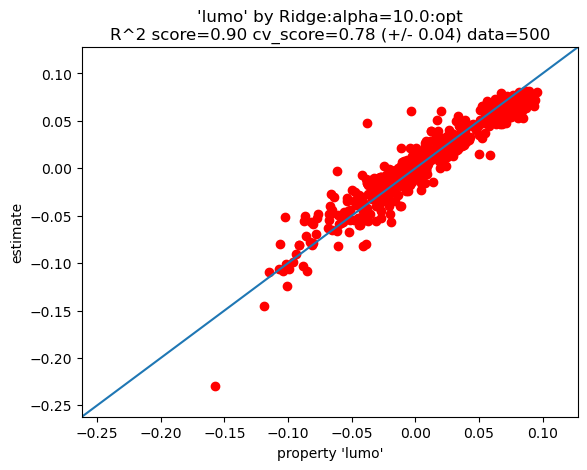

In [37]:
# optimize hyperparameters by grid search
# default seach grid is param_grid = {'alpha':np.logspace(-5, 1, 7)}
model = moldata.optimize_regression_model(RidgeRegressionModel(moldata, 'lumo', features_fp))
model.plot_estimate()

The <font color="Blue">MolData.select_features()</font> method selects important features and improves the accuracy of the regression model. After the feature selection, the regression model uses only selected features.

feature selection target='lumo': data_size=500: model:Ridge:alpha=0.01:ini threshold=None
feature size:121 -> 37
regression model cross validation target='lumo': data_size=500: model:Ridge n_splits=3 shuffle=True
R^2 score=0.86 cv_score=0.80 (+/- 0.03)


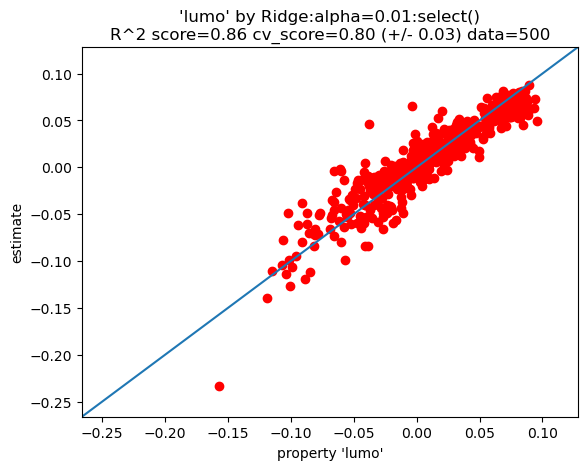

In [38]:
# feature selection with optimized hyperparameter
model = moldata.select_features(RidgeRegressionModel(moldata, 'lumo', features_fp, alpha=0.01))
model.plot_estimate()

You can optimize hyperparameters and select features at a time by using <font color="Blue">MolData.optimize_and_select_features()</font>.

regression model parameter optimization target='lumo': data_size=500: model:Ridge n_splits=3 shuffle=True
optimized parameters: {'alpha': 10.0}
regression model cross validation target='lumo': data_size=500: model:Ridge n_splits=3 shuffle=True
R^2 score=0.90 cv_score=0.79 (+/- 0.03)
feature selection target='lumo': data_size=500: model:Ridge:alpha=10.0:opt threshold=None
feature size:121 -> 39
regression model cross validation target='lumo': data_size=500: model:Ridge n_splits=3 shuffle=True
R^2 score=0.86 cv_score=0.80 (+/- 0.04)


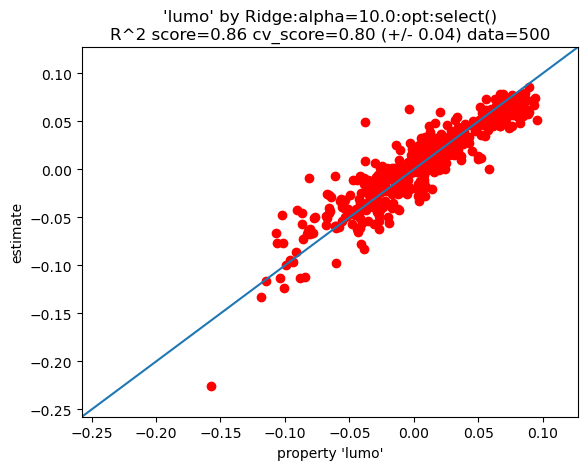

In [39]:
# feature selection with optimized hyperparameter
model = moldata.optimize_and_select_features(RidgeRegressionModel(moldata, 'lumo', features_fp))
model.plot_estimate()

#### (1-3) Lasso Regression Model

<font color="Coral">LassoRegressionModel</font> is implemented by wraping [Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso) of the [scikit-learn](https://scikit-learn.org/stable/index.html) package. It minimizes the residual sum of squares with an L1 regularization term.

$$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$$


LassoRegressionModel has hyperparamter <font color="Blue">alpha</font> ($\alpha$). The model is useful for a large and sparse feature vector. However, a lot of colinerity in the feature vector may result in unstable performance. 

regression model parameter optimization target='lumo': data_size=500: model:Lasso n_splits=3 shuffle=True
optimized parameters: {'alpha': 0.0001}
regression model cross validation target='lumo': data_size=500: model:Lasso n_splits=3 shuffle=True
R^2 score=0.90 cv_score=0.78 (+/- 0.04)


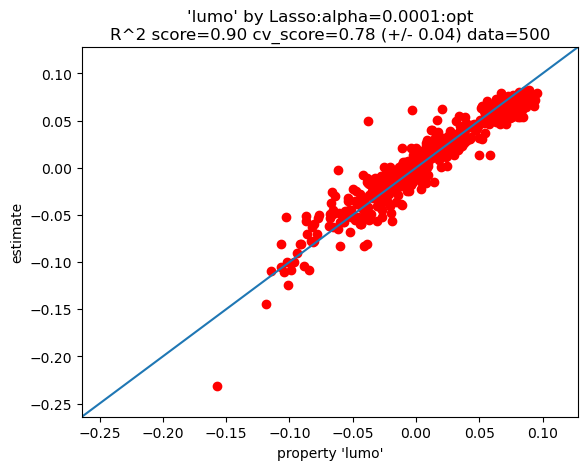

In [40]:
# optimize hyperparameters by grid seach
# default seach grid is param_grid = {'alpha':np.logspace(-5, 1, 7)}
model = moldata.optimize_regression_model(LassoRegressionModel(moldata, 'lumo', features_fp))
model.plot_estimate()

feature selection target='lumo': data_size=500: model:Lasso:alpha=0.01:ini threshold=None
feature size:121 -> 6
regression model cross validation target='lumo': data_size=500: model:Lasso n_splits=3 shuffle=True
R^2 score=0.43 cv_score=0.42 (+/- 0.02)


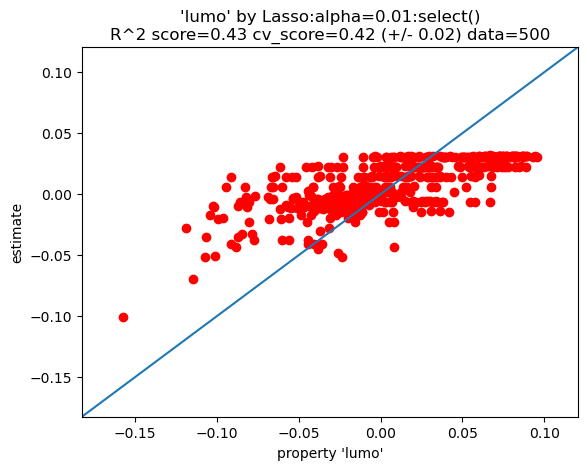

In [41]:
# feature selection with specified hyperparameter
model = moldata.select_features(LassoRegressionModel(moldata, 'lumo', features_fp, alpha=0.01))
model.plot_estimate()

regression model parameter optimization target='lumo': data_size=500: model:Lasso n_splits=3 shuffle=True
optimized parameters: {'alpha': 0.0001}
regression model cross validation target='lumo': data_size=500: model:Lasso n_splits=3 shuffle=True
R^2 score=0.90 cv_score=0.79 (+/- 0.04)
feature selection target='lumo': data_size=500: model:Lasso:alpha=0.0001:opt threshold=None
feature size:121 -> 93
regression model cross validation target='lumo': data_size=500: model:Lasso n_splits=3 shuffle=True
R^2 score=0.90 cv_score=0.79 (+/- 0.03)


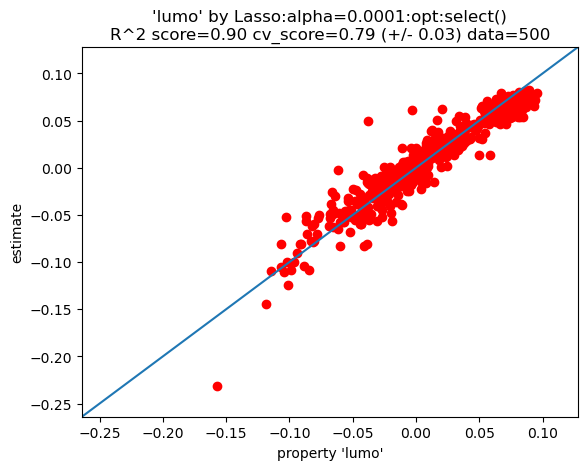

In [42]:
# feature selection with optimized hyperparameter
model = moldata.optimize_and_select_features(LassoRegressionModel(moldata, 'lumo', features_fp))
model.plot_estimate()

#### (1-4) ElasticNet Regression Model

<font color="Coral">ElasticNetRegressionModel</font> is implemented by wraping [ElasticNet](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net) of the [scikit-learn](https://scikit-learn.org/stable/index.html) package. It minimizes the residual sum of squares with L1 and L2 regularization terms.

$$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha \rho ||w||_1 +
\frac{\alpha(1-\rho)}{2} ||w||_2 ^ 2}$$


The model has hyperparameters <font color="Blue">alpha</font> ($\alpha$) and <font color="Blue">l1_ratio</font> ($\rho$). Since the model has both of the characteristics of Ridge and Lasso, it is useful for a large and sparse feature vector with some colenerity.

regression model parameter optimization target='lumo': data_size=500: model:ElasticNet n_splits=3 shuffle=True
optimized parameters: {'alpha': 0.1, 'l1_ratio': 0.0}
regression model cross validation target='lumo': data_size=500: model:ElasticNet n_splits=3 shuffle=True
R^2 score=0.89 cv_score=0.80 (+/- 0.02)


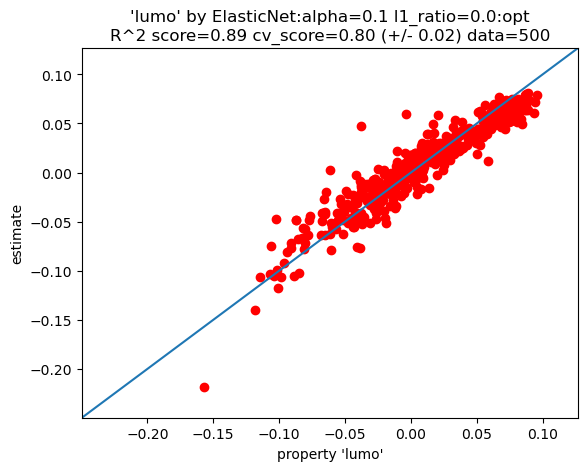

In [43]:
# optimize hyperparameters by grid seach
# default seach grid is param_grid = {'alpha':np.logspace(-5, 1, 7), 'l1_ratio':np.linspace(0.0, 1.0, 6)}
model = moldata.optimize_regression_model(ElasticNetRegressionModel(moldata, 'lumo', features_fp))
model.plot_estimate()

feature selection target='lumo': data_size=500: model:ElasticNet:alpha=0.01 l1_ratio=0.2:ini threshold=None
feature size:121 -> 28
regression model cross validation target='lumo': data_size=500: model:ElasticNet n_splits=3 shuffle=True
R^2 score=0.79 cv_score=0.74 (+/- 0.03)


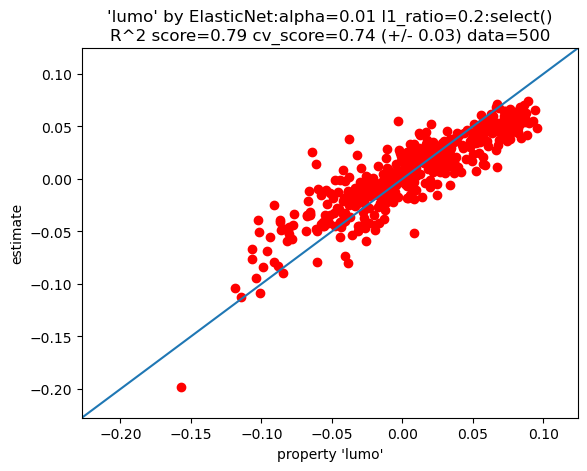

In [44]:
# feature selection with specified hyperparameter
model = moldata.select_features(ElasticNetRegressionModel(moldata, 'lumo', features_fp, alpha=0.01, l1_ratio=0.2))
model.plot_estimate()

regression model parameter optimization target='lumo': data_size=500: model:ElasticNet n_splits=3 shuffle=True
optimized parameters: {'alpha': 0.1, 'l1_ratio': 0.0}
regression model cross validation target='lumo': data_size=500: model:ElasticNet n_splits=3 shuffle=True
R^2 score=0.89 cv_score=0.80 (+/- 0.03)
feature selection target='lumo': data_size=500: model:ElasticNet:alpha=0.1 l1_ratio=0.0:opt threshold=None
feature size:121 -> 42
regression model cross validation target='lumo': data_size=500: model:ElasticNet n_splits=3 shuffle=True
R^2 score=0.86 cv_score=0.80 (+/- 0.03)


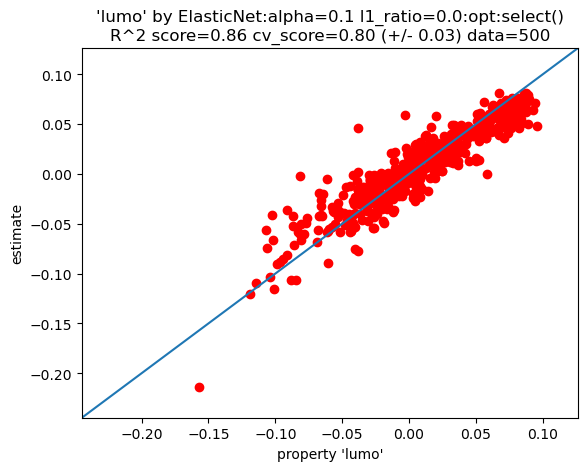

In [45]:
# feature selection with optimized hyperparameter
model = moldata.optimize_and_select_features(ElasticNetRegressionModel(moldata, 'lumo', features_fp))
model.plot_estimate()

### (2) Non-linear Models

#### (2-1) Random Forest Regression Model

<font color="Coral">RandomForestRegressionModel</font> is implemented by wrapping [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) of the [scikit-learn](https://scikit-learn.org/stable/index.html) package. The model fits a number of classifying decision trees on various samples of the dataset and obtains average values, thus improving the predictive accuracy as well as controlling overfitting. 

The model has hyperparameter <font color="Blue">min_samples_split</font>.

Feature selection is performed by comparing ``feature_importances_`` of the model with the threshold of the feature selection.

regression model parameter optimization target='lumo': data_size=500: model:RandomForestRegressor n_splits=3 shuffle=True
optimized parameters: {'min_samples_split': 3}
regression model cross validation target='lumo': data_size=500: model:RandomForestRegressor n_splits=3 shuffle=True
R^2 score=0.96 cv_score=0.72 (+/- 0.04)
feature selection target='lumo': data_size=500: model:RandomForestRegressor:min_samples_split=3:opt threshold=None
feature size:121 -> 121
regression model cross validation target='lumo': data_size=500: model:RandomForestRegressor n_splits=3 shuffle=True
R^2 score=0.96 cv_score=0.72 (+/- 0.03)


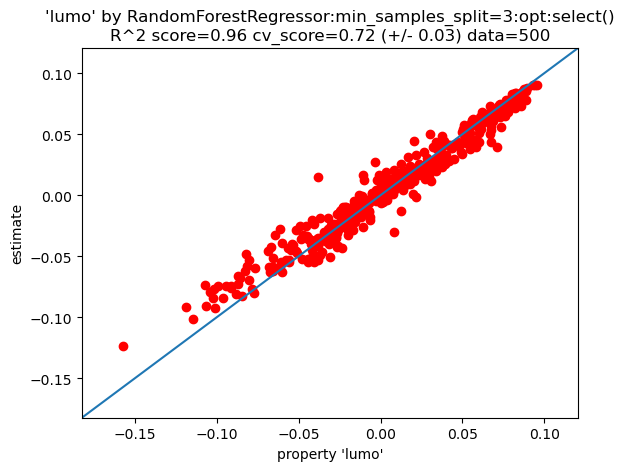

In [46]:
# optimize hyperparameters by grid seach
# default seach grid is 
# param_grid = {'min_samples_split': np.arange(2, 4, dtype=np.int)}
model = moldata.optimize_and_select_features(RandomForestRegressionModel(moldata, 'lumo', features_fp))
model.plot_estimate()

### (3) Models Stored in MolData Object

So far, we have applied several regression models to the same `moldata`. All the results are stored in the `moldata` object, and you can retreive the model with fitted coefficients at any time. 

<font color="Blue">MolData.print_regression_models()</font> displays the information on the saved models. Regression models are classified by their`target property` and `feature vector`. They are shown with their status (parameters optimized or features selecetd) and accuracy.

In [47]:
# print saved regression models
moldata.print_regression_models()

regression model list:''
 * target property: 'lumo'
  + features: |aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|
   0: R^2 score=0.90 cv_score=0.76 (+/- 0.05) size=121/121 LinearRegression:fit
   1: R^2 score=0.90 cv_score=0.76 (+/- 0.06) size=121/121 Ridge:alpha=0.01:fit
   2: R^2 score=0.90 cv_score=0.78 (+/- 0.04) size=121/121 Ridge:alpha=10.0:opt
   3: R^2 score=0.86 cv_score=0.80 (+/- 0.03) size=37/121 Ridge:alpha=0.01:select()
   4: R^2 score=0.86 cv_score=0.80 (+/- 0.04) size=39/121 Ridge:alpha=10.0:opt:select()
   5: R^2 score=0.90 cv_score=0.78 (+/- 0.04) size=121/121 Lasso:alpha=0.0001:opt
   6: R^2 score=0.43 cv_score=0.42 (+/- 0.02) size=6/121 Lasso:alpha=0.01:select()
   7: R^2 score=0.90 cv_score=0.79 (+/- 0.03) size=93/121 Lasso:alpha=0.0001:opt:select()
   8: R^2 score=0.89 cv_score=0.80 (+/- 0.02) size=121/121 ElasticNet:alpha=0.1 l1_ratio=0.0:opt
   9: R^2 score=0.79 cv_score=0.74 (+/- 0.03) size=28/121 ElasticNet:alpha=0.01 l1_ratio=0.2:select()
   1

<font color="Blue">MolData.get_regression_model_by_index()</font> with specifying a `target property` and a `feature vector` retrieves a necessary regression model.

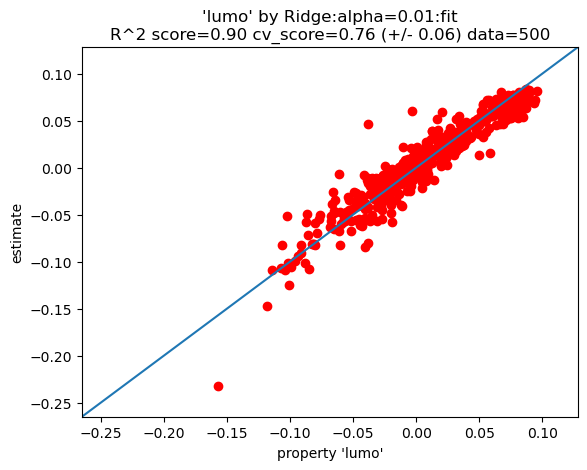

In [48]:
# retrieve 1-th regression model for a target property 'lumo' and feature vector 'features_fp'
model = moldata.get_regression_model_by_index('lumo', features_fp.id, 1)
model.plot_estimate()

### (4) Summary of Stored Models

<font color="Blue">MolData.get_regression_model_summary()</font> returns a summary table for regression models for a specified target property sorted by the cross validation score.

In [49]:
# get a summary of regression models for property 'lumo'
legends = {fs_atom.id: 'atom',
           fs_ring.id: 'ring',
           fs_aring.id: 'aring',
           fs_fp_structure1.id: 'fp1'}
df_model_lumo = moldata.get_regression_model_summary('lumo', legends=legends)
df_model_lumo

model  \
0   <molgx.Prediction.ElasticNetRegressionModel ob...   
1   <molgx.Prediction.RidgeRegressionModel object ...   
2   <molgx.Prediction.RidgeRegressionModel object ...   
3   <molgx.Prediction.ElasticNetRegressionModel ob...   
4   <molgx.Prediction.LassoRegressionModel object ...   
5   <molgx.Prediction.LassoRegressionModel object ...   
6   <molgx.Prediction.RidgeRegressionModel object ...   
7   <molgx.Prediction.LinearRegressionModel object...   
8   <molgx.Prediction.RidgeRegressionModel object ...   
9   <molgx.Prediction.ElasticNetRegressionModel ob...   
10  <molgx.Prediction.RandomForestRegressionModel ...   
11  <molgx.Prediction.LassoRegressionModel object ...   

                                             model_id     score  cv_score  \
0      ElasticNet:alpha=0.1 l1_ratio=0.0:opt:select()  0.855129  0.803527   
1                           Ridge:alpha=0.01:select()  0.861051  0.801728   
2                       Ridge:alpha=10.0:opt:select()  0.858104  0.800847   
3               ElasticNet:alpha=0.1 l1_ratio=0.0:opt  0.892388  0.797159   
4                     Lasso:alpha=0.0001:opt:select()  0.900422  0.794188   
5                              Lasso:alpha=0.0001:opt  0.900414  0.784034   
6                                Ridge:alpha=10.0:opt  0.901140  0.782212   
7                                LinearRegression:fit  0.902852  0.764150   
8                                Ridge:alpha=0.01:fit  0.902852  0.763814   
9         ElasticNet:alpha=0.01 l1_ratio=0.2:select()  0.790450  0.743344   
10  RandomForestRegressor:min_samples_split=3:opt:...  0.957557  0.719378   
11                          Lasso:alpha=0.01:select()  0.430045  0.417538   

    cv_score(std)      rmse  size  aring (3)  fp1 (109)  atom (4)  ring (5)  
0        0.029036  0.018264    42          3         36         2         1  
1        0.026421  0.017887    37          3         29         2         3  
2        0.035350  0.018076    39          3         32         2         2  
3        0.023626  0.015741   121          3        109         4         5  
4        0.033744  0.015142    93          2         85         2         4  
5        0.036623  0.015143   121          3        109         4         5  
6        0.044973  0.015088   121          3        109         4         5  
7        0.053058  0.014956   121          3        109         4         5  
8        0.060485  0.014956   121          3        109         4         5  
9        0.030531  0.021966    28          2         23         1         2  
10       0.033241  0.009886   121          3        109         4         5  
11       0.024152  0.036227     6          0          4         1         1

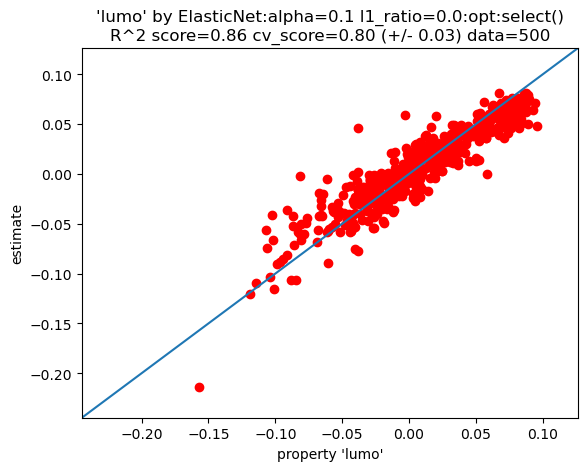

In [50]:
# get a best regression modesl for property 'lumo'
best_model_lumo = df_model_lumo['model'][0]
best_model_lumo.plot_estimate()

regression model parameter optimization target='homo': data_size=500: model:Ridge n_splits=3 shuffle=True
optimized parameters: {'alpha': 100.0}
regression model cross validation target='homo': data_size=500: model:Ridge n_splits=3 shuffle=True
R^2 score=0.79 cv_score=0.61 (+/- 0.05)
feature selection target='homo': data_size=500: model:Ridge:alpha=100.0:opt threshold=None
feature size:121 -> 48
regression model cross validation target='homo': data_size=500: model:Ridge n_splits=3 shuffle=True
R^2 score=0.74 cv_score=0.63 (+/- 0.05)
regression model parameter optimization target='homo': data_size=500: model:Lasso n_splits=3 shuffle=True
optimized parameters: {'alpha': 0.0001}
regression model cross validation target='homo': data_size=500: model:Lasso n_splits=3 shuffle=True
R^2 score=0.81 cv_score=0.60 (+/- 0.05)
feature selection target='homo': data_size=500: model:Lasso:alpha=0.0001:opt threshold=None
feature size:121 -> 90
regression model cross validation target='homo': data_size=5

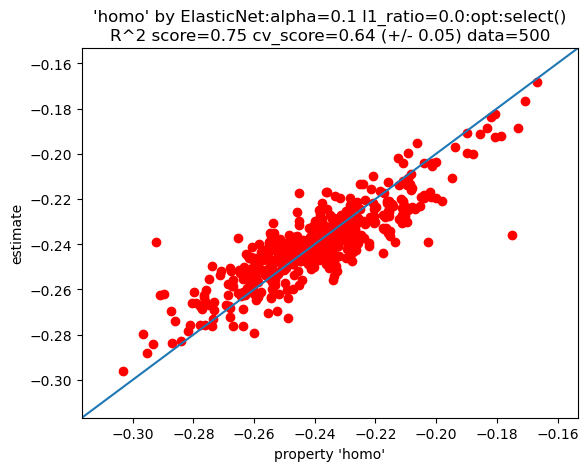

In [51]:
# apply a regression models to another target property 'homo'
model = moldata.optimize_and_select_features(RidgeRegressionModel(moldata, 'homo', features_fp))
model = moldata.optimize_and_select_features(LassoRegressionModel(moldata, 'homo', features_fp))
model = moldata.optimize_and_select_features(ElasticNetRegressionModel(moldata, 'homo', features_fp))
model = moldata.optimize_and_select_features(RandomForestRegressionModel(moldata, 'homo', features_fp))

# get a best regression modesl for property 'homo'
df_model_homo = moldata.get_regression_model_summary('homo', legends=legends)
best_model_homo = df_model_homo['model'][0]
best_model_homo.plot_estimate()

## (4) Feature Estimation

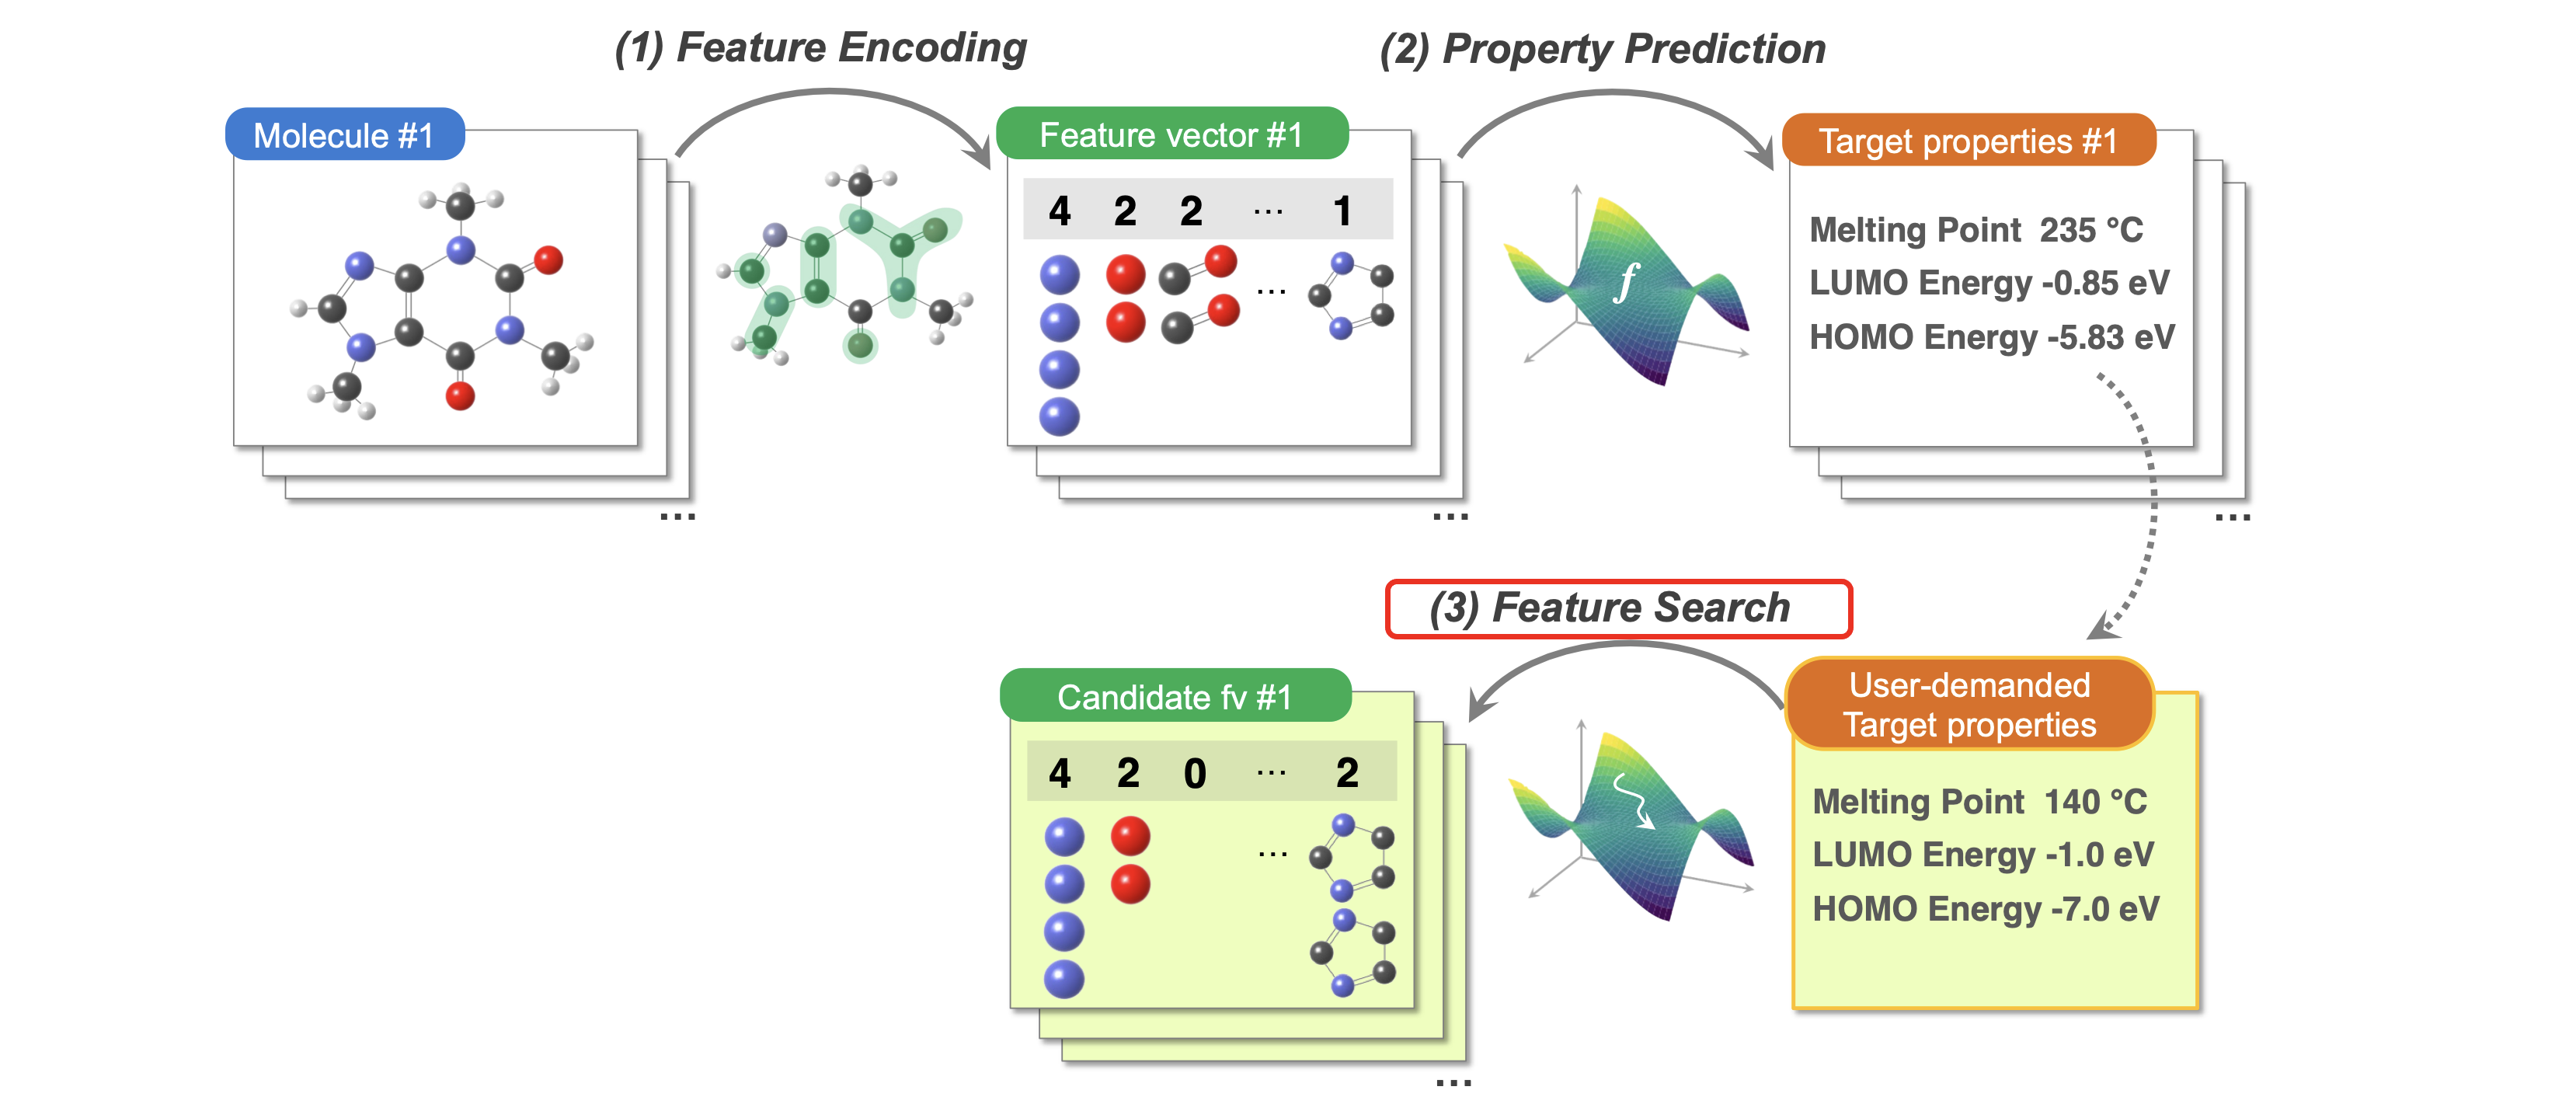

We estimate feature vector values as a first step of solving the inverse problem in material discovery. 

The <font color="Blue">Moldata.estimate_feature()</font> method estimates feature vector values ${\rm fv}$ from a target property value $v_p$ and a regression model $f_p()$ by minimizing the score of a feature vector $v$; the sum of the square error of the estimated value normalized by the variance $\sigma_p^2$ of the prediction, and a penalty of the violations of structural constraints. The structural constraints are the realizability of a connected molecular structure from substructures represented in a feature vector.


\begin{equation*}
\newcommand{\argmin}{\mathop{\rm arg~min}\limits}
{\rm fv} = \argmin_{v \in I^n} \{ \frac{|v_p - f_p(v)|^2}{\sigma_p^2} + {\rm violation}(v) \}
\end{equation*}


Generated feature estimates are stored in a moldata object, and you can check it with <font color="Blue">MolData.print_feature_estimates()</font>.

<font color="Blue">MolData.estimate_feature()</font> takes a list of models and a design parameter object as an argument. A design parameter is a collection of parameters for the inverse design, which consists of target property values. It is also used as a key to store the results for feature estimation in a MolData object. 

### (1) Feature Estimation for a Single Target Property

You can define the design parameter by using <font color="Blue">Moldata.make_design_parameter()</font>. Since the design parameter is used as a key, the same design parameter should be used in both feature estimation and structure generation.

A target which needs to be satisfied is specified by a dictionary of a target property name and its target value with single or range (ex. {'home': (-0.23, -0.20)}).

In [52]:
# make a design parameter
design_param = moldata.make_design_parameter({'homo': -0.25}, prediction_error=0.1)
# estimate feature vector
feature_estimates = moldata.estimate_feature([best_model_homo], design_param, num_candidate=5)

In [53]:
# print estimated features
feature_estimates.print(design_param)

estimated features for label component ''
 * target value=((-0.25, -0.25),) params=(0, 0, False, 2.0, 0, None, None, 0.1)
  + feature_vector[0]:{aring:5:[0] aring:6:[0] fp:r1[C]:*#C:[0] fp:r1[C]:*N:[0] fp:r1[C]:*O:[0] fp:r1[C]:C*#N:[0] fp:r1[C]:C*(=O)O:[0] fp:r1[C]:C*(C)(C)O:[0] fp:r1[C]:C*(C)N:[0] fp:r1[C]:C*(N)O:[0] fp:r1[C]:C*=O:[0] fp:r1[C]:C*C:[1] fp:r1[C]:C*N:[1] fp:r1[C]:C=*(C)C:[0] fp:r1[C]:C=*(C)N:[0] fp:r1[C]:N*(=O)O:[0] fp:r1[C]:N=*(N)N:[0] fp:r1[C]:O=*(O)O:[0] fp:r1[C]:O=*=O:[0] fp:r1[C]:O=*O:[1] fp:r1[N]:*#C:[0] fp:r1[N]:*C:[0] fp:r1[N]:C*C:[0] fp:r1[N]:N*N:[0] fp:r1[O]:*=C:[1] fp:r1[c]:C*(n)n:[0] fp:r1[c]:c*(C)n:[0] fp:r1[c]:c*(N)o:[0] fp:r1[c]:c*(c)=N:[0] fp:r1[c]:c*(c)C:[0] fp:r1[c]:c*(c)N:[0] fp:r1[c]:c*(c)O:[0] fp:r1[c]:c*(n)N:[0] fp:r1[c]:c*(n)O:[0] fp:r1[c]:c*(o)O:[0] fp:r1[c]:c*c:[0] fp:r1[c]:n*n:[0] fp:r1[n]:c*(c)C:[0] fp:r1[n]:c*c:[0] fp:r1[n]:c*o:[0] fp:r1[o]:c*n:[0] fp:r1[o]:n*n:[0] atom:C:[6] atom:O:[2] ring:4:[1] ring:5:[1] ring:6:[0] ring:7:[0]}
  + feature_

In [54]:
# get estimated features in dataframe
feature_estimates.get_dataframe(design_param)

aring:5 aring:6 fp:r1[C]:*#C fp:r1[C]:*N fp:r1[C]:*O fp:r1[C]:C*#N  \
0       0       0            0           0           0             0   
1       0       0            0           1           0             1   
2       0       0            0           0           0             1   
3       0       0            0           0           0             0   
4       0       0            1           0           0             0   

  fp:r1[C]:C*(=O)O fp:r1[C]:C*(C)(C)O fp:r1[C]:C*(C)N fp:r1[C]:C*(N)O  ...  \
0                0                  0               0               0  ...   
1                0                  0               0               0  ...   
2                0                  0               0               0  ...   
3                1                  1               1               0  ...   
4                0                  1               0               0  ...   

  fp:r1[n]:c*c fp:r1[n]:c*o fp:r1[o]:c*n fp:r1[o]:n*n atom:C atom:O ring:4  \
0            0            0            0            0      6      2      1   
1            0            0            0            0      7      0      0   
2            0            0            0            0      5      0      0   
3            0            0            0            0      6      2      0   
4            0            0            0            0      7      2      1   

  ring:5 ring:6 ring:7  
0      1      0      0  
1      0      0      0  
2      0      0      0  
3      1      0      0  
4      0      0      0  

[5 rows x 48 columns]

The <font color="Blue">MolData.print_feature_estimates()</font> method displays the results of feature estimation. You can find "<font color="Green">target value=((-0.25, -0.25),) params=(0, 0, False, 2.0, 0, None, None, 0.1) </font>" under the regression model used for the feature estimation. This means 5 estimates of a feature vector are obtained by the feature estimation.

In [55]:
# check the result of feature estimation for ('homo', -0.25)
moldata.print_feature_estimates()

feature estimate list:''
 * target property: 'homo'
  + |aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|
   0: ElasticNet:alpha=0.1 l1_ratio=0.0:opt:select()
    - target value=((-0.25, -0.25),) params=(0, 0, False, 2.0, 0, None, None, 0.1)
     0: 20241219095855535V0 vector(48) score=0.004
     1: 20241219095855535V1 vector(48) score=0.022
     2: 20241219095855535V2 vector(48) score=0.002
     3: 20241219095855535V3 vector(48) score=0.000
     4: 20241219095855535V4 vector(48) score=0.023


Since estimated feature vectors are stored in the moldata object with a model and a design parameter as a key, new feature vectors are added to an existing entry if you call <font color="Blue">MolData.estimate_features()</font> with the same parameters.

In [56]:
# estimate 5 more feature vectors with the same parameter before
feature_estimates = moldata.estimate_feature([best_model_homo], design_param, num_candidate=5)

The following results indicate that 7 vectors are stored in the same entry.

In [57]:
# check the result of feature estimation for ('homo', -0.25)
moldata.print_feature_estimates()

feature estimate list:''
 * target property: 'homo'
  + |aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|
   0: ElasticNet:alpha=0.1 l1_ratio=0.0:opt:select()
    - target value=((-0.25, -0.25),) params=(0, 0, False, 2.0, 0, None, None, 0.1)
     0: 20241219095855535V0 vector(48) score=0.004
     1: 20241219095855535V1 vector(48) score=0.022
     2: 20241219095855535V2 vector(48) score=0.002
     3: 20241219095855535V3 vector(48) score=0.000
     4: 20241219095855535V4 vector(48) score=0.023
     5: 20241219095910346V5 vector(48) score=0.000
     6: 20241219095910346V6 vector(48) score=0.000
     7: 20241219095910346V7 vector(48) score=0.000
     8: 20241219095910346V8 vector(48) score=0.000
     9: 20241219095910346V9 vector(48) score=0.120


### (2) Feature Estimation for Multiple Target Properties

Feature vectors satisfying multiple target property values can also be estimated in the same way.

In [58]:
# get 2 candidates for estimated feature vectors for a target value (homo: (-0.25,-0.20)), (lumo: (0.05, 0.10))
design_param = moldata.make_design_parameter({'homo': (-0.25, -0.20), 'lumo': (0.05, 0.10)}, prediction_error=0.1)
feature_estimates = moldata.estimate_feature([best_model_homo, best_model_lumo], design_param, num_candidate=2)

Using design parameter consisting of ``'homo'``=(-0.25, -0.20) and ``'lumo'``=(0.05, 0.10), you can find "<font color="Green">target value=((-0.25, -0.2), (0.05, 0.1)) params=(0, 0, False, 2.0, 0, None, None, 0.1)</font>" and a list of  feature vectors found when the Lasso regression model is used for the feature estimation.

In [59]:
# check the result of feature estimation
moldata.print_feature_estimates()

feature estimate list:''
 * target property: 'homo'
  + |aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|
   0: ElasticNet:alpha=0.1 l1_ratio=0.0:opt:select()
    - target value=((-0.25, -0.25),) params=(0, 0, False, 2.0, 0, None, None, 0.1)
     0: 20241219095855535V0 vector(48) score=0.004
     1: 20241219095855535V1 vector(48) score=0.022
     2: 20241219095855535V2 vector(48) score=0.002
     3: 20241219095855535V3 vector(48) score=0.000
     4: 20241219095855535V4 vector(48) score=0.023
     5: 20241219095910346V5 vector(48) score=0.000
     6: 20241219095910346V6 vector(48) score=0.000
     7: 20241219095910346V7 vector(48) score=0.000
     8: 20241219095910346V8 vector(48) score=0.000
     9: 20241219095910346V9 vector(48) score=0.120
 * target property: 'homo','lumo'
  + |aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|
    |aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|
   0: ElasticNet:alpha=0.1 l1_ratio=0.0:opt:select()
      Elast

## (5) Structure Generation

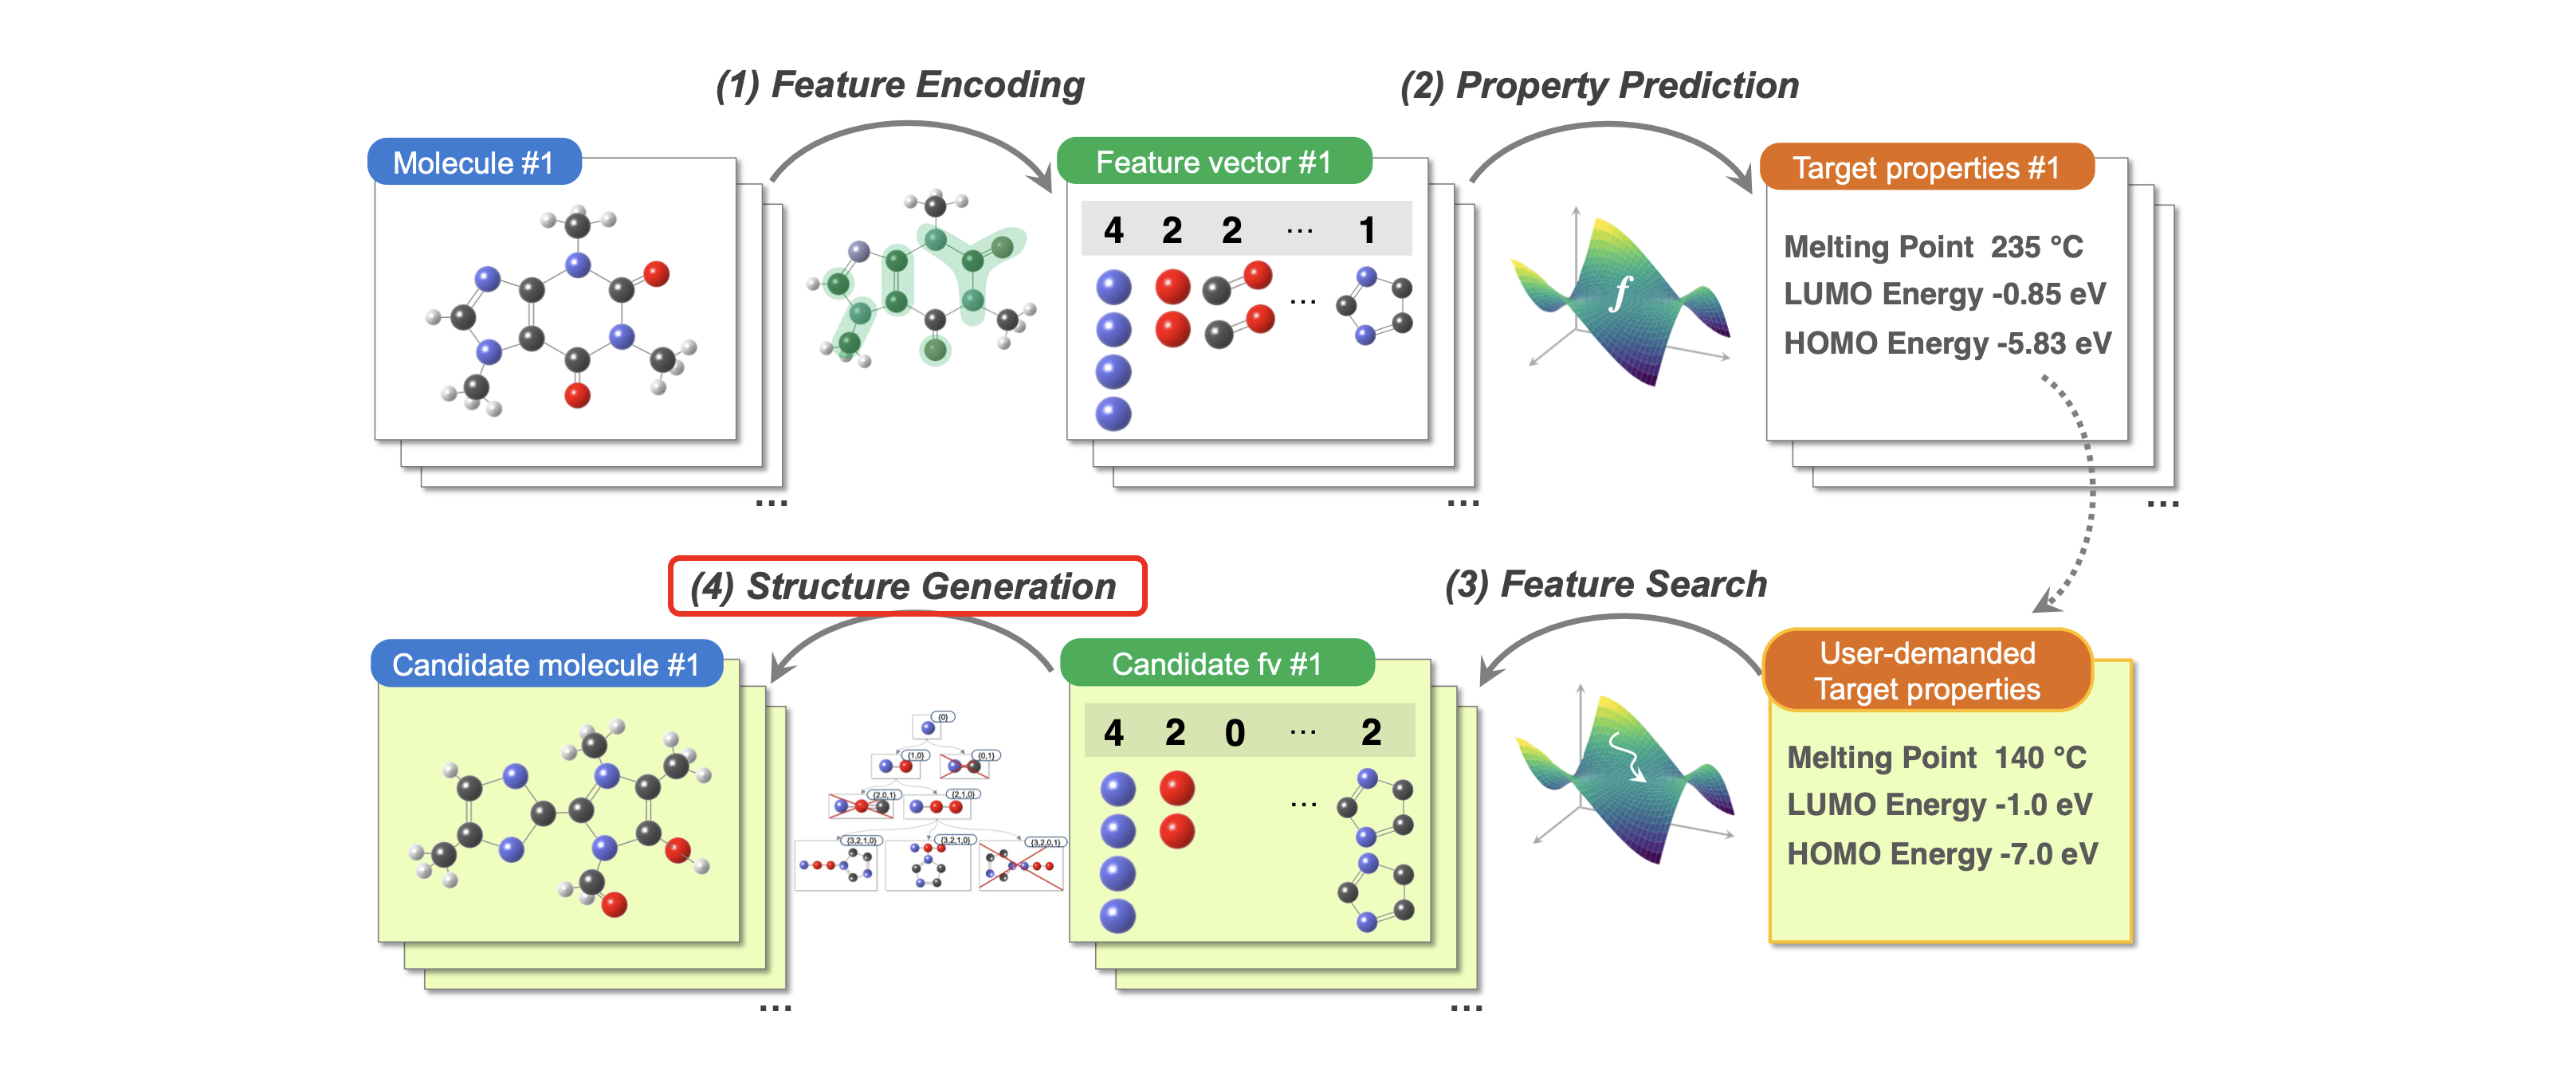

Molecules satisfying the estimated feature vectors are exhastively generated in the last step of the material discovery process. 

The <font color="Blue">MolData.generate_molecule()</font> method generates molecular structures constrained by estimated feature vector. To retrieve estimated feature vectors, the same arguments (a list of models and a design parameters) as the feature estimation have to be specified. Generated molecules in SMILES notation are stored in the same entry of the estimated feature vectors in a moldata object. <font color="Blue">MolData.print_feature_estimates()</font> displays the results.

In [60]:
# generate candidate molecules from 8 estimated feature vectors
design_param = moldata.make_design_parameter({'homo': -0.25}, prediction_error=0.1)
candidate_molecules = moldata.generate_molecule([best_model_homo], design_param, without_estimate=False, max_gen=8, max_solution=20, max_node=200000)

Using the <font color="Blue">MolData.print_feature_estimates()</font> method, you can find "<font color="Green">molecules=[...]</font>" under the corresponding feature estimate entry. The number in each feature vector means the number of generated molecules which match that feature estimate and which are already in the training data. The number in the "no vector" category indicates the number of molecules with new structures. 

In [61]:
# check the result of structure generation for ('homo', -0.25)
moldata.print_feature_estimates()

feature estimate list:''
 * target property: 'homo'
  + |aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|
   0: ElasticNet:alpha=0.1 l1_ratio=0.0:opt:select()
    - target value=((-0.25, -0.25),) params=(0, 0, False, 2.0, 0, None, None, 0.1)
     0: 20241219095855535V0 vector(48) score=0.004: molecules=0
     1: 20241219095855535V1 vector(48) score=0.022: molecules=0
     2: 20241219095855535V2 vector(48) score=0.002: molecules=0
     3: 20241219095855535V3 vector(48) score=0.000: molecules=0
     4: 20241219095855535V4 vector(48) score=0.023: molecules=0
     5: 20241219095910346V5 vector(48) score=0.000: molecules=0
     6: 20241219095910346V6 vector(48) score=0.000: molecules=0
     7: 20241219095910346V7 vector(48) score=0.000: molecules=0
     8: 20241219095910346V8 vector(48) score=0.000
     9: 20241219095910346V9 vector(48) score=0.120
     10: 20241219095918903 no vector: molecules=20
 * target property: 'homo','lumo'
  + |aromatic_ring|finger_print_structure:rad

If there are estimated feature vectors unused in the previous sturcture generation, you can apply the structure generation only to those estimated feature vectors simply by calling the sturcture generation again.

In [62]:
# generate candidate molecules from 2 other estimated feature vectors by beam search
candidate_molecules = moldata.generate_molecule([best_model_homo], design_param, without_estimate=False, max_gen=2, max_solution=20, 
                                                max_node=1000000, beam_size=1000)

The <font color="Blue">MolData.print_feature_estimates()</font> method displays the results. 

In [63]:
# check the result of structure generation for ('homo', -0.25)
moldata.print_feature_estimates()

feature estimate list:''
 * target property: 'homo'
  + |aromatic_ring|finger_print_structure:radius=1|heavy_atom|ring|
   0: ElasticNet:alpha=0.1 l1_ratio=0.0:opt:select()
    - target value=((-0.25, -0.25),) params=(0, 0, False, 2.0, 0, None, None, 0.1)
     0: 20241219095855535V0 vector(48) score=0.004: molecules=0
     1: 20241219095855535V1 vector(48) score=0.022: molecules=0
     2: 20241219095855535V2 vector(48) score=0.002: molecules=0
     3: 20241219095855535V3 vector(48) score=0.000: molecules=0
     4: 20241219095855535V4 vector(48) score=0.023: molecules=0
     5: 20241219095910346V5 vector(48) score=0.000: molecules=0
     6: 20241219095910346V6 vector(48) score=0.000: molecules=0
     7: 20241219095910346V7 vector(48) score=0.000: molecules=0
     8: 20241219095910346V8 vector(48) score=0.000: molecules=0
     9: 20241219095910346V9 vector(48) score=0.120: molecules=0
     10: 20241219095918903 no vector: molecules=20
     11: 20241219100018520 no vector: molecules=20
 *

The <font color="Blue">MolData.draw_candidate_molecules()</font> method draws the generted molecules.

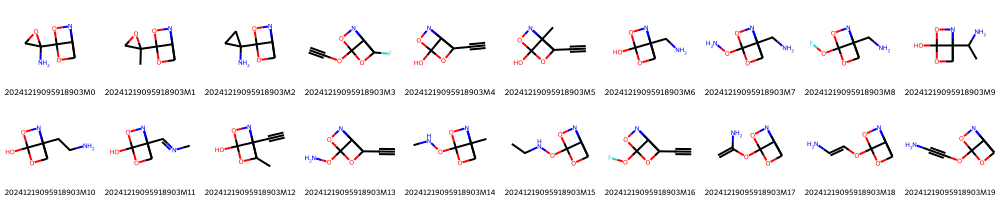

In [64]:
# draw generated molecules
moldata.draw_candidate_molecules([best_model_homo], design_param, max_draw=20)

The <font color="Blue">MolData.get_generated_molecule_summary()</font> method returns a dataframe of generated molecules with their estimated target property values. 

In [65]:
# evaluate generated molecules
df = moldata.get_generated_molecule_summary([best_model_homo], design_param)
HTML(df.to_html(escape=False))

## (6) Feature Estimation and Structure Generation

The <font color="Blue">MolData.estimate_and_generate()</font> method iterates feature estimation and structure generation until the required number of molecules are obtained. Using this method may be simpler than calling two separate methods shown in the previous example. 

In [66]:
# get 50 candidate molecules for a target value ('homo', -0.25)
design_param = moldata.make_design_parameter({'homo': -0.25}, prediction_error=0.1)
# generate molecule
candidate_molecules = moldata.estimate_and_generate([best_model_homo], design_param, max_candidate=50, max_molecule=50,
                                                    num_candidate=10, max_solution=50, max_node=200000, beam_size=1000)

In [67]:
# evaluate generated molecules  ('homo', -0.25)
df = moldata.get_generated_molecule_summary([best_model_homo], design_param)
HTML(df.to_html(escape=False))

## (7) Structure Generation without Feature Estimation

You can directly generate molecules without feature estimation by using <font color="Blue">MolData.generate_molecule()</font> method with ``without_estimate=``**True** (default).

In [68]:
# get 20 candidate molecules for a target value 
design_param = moldata.make_design_parameter({'homo': -0.25}, prediction_error=0.5)
# generate molecule
candidate_molecules = moldata.generate_molecule([best_model_homo], design_param, without_estimate=True,
                                                max_solution=20, max_node=200000, beam_size=1000)

In [69]:
df = moldata.get_generated_molecule_summary([best_model_homo], design_param)
HTML(df.to_html(escape=False))